EDA에서 찾은 인사이트를 통해 전처리와 머신러닝 모델, RFM 모델을 최적화합니다.\
파이프라인 내 모델을 살펴보고 각자의 역할에서 최상의 성능을 낼 수 있는 값을 찾습니다.

## 패키지 및 샘플 로딩


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings('ignore')

import datetime as dt
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import classification_report

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/data/co_data/sample_01.pkl')

## 함수 정의

### 파생 피처 생성

#### 날짜 및 충성도 기능

In [ ]:
#날짜 파싱

def get_date(data):
  data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')
  data['year'] = data['date'].dt.year
  data['month'] = data['date'].dt.month
  data['week'] = data['date'].dt.week
  data['weekday'] = data['date'].dt.weekday

  data['date'] = data['date'].apply(lambda x: dt.date(x.year, x.month, x.day))

cols = 'month'

#월,주,요일별 방문

def get_date_feature(data):
  month_visit_count = data.groupby(['fullVisitorId'])['month'].agg('count').reset_index()
  week_visit_count = data.groupby(['fullVisitorId'])['week'].agg('count').reset_index()
  weekdaily_visit_count = data.groupby(['fullVisitorId','year','week'])['weekday'].agg('count').reset_index()
  weekdaily_visit_count = weekdaily_visit_count.groupby(['fullVisitorId'])['weekday'].agg('mean').reset_index()

  month_visit_count.rename(columns={'month':'monthly_visit'},inplace=True)
  week_visit_count.rename(columns={'week':'weekly_visit'},inplace=True)
  weekdaily_visit_count.rename(columns={'weekday':'weekdaily_visit'},inplace=True)

  data = data.merge(month_visit_count,on='fullVisitorId',how='left')
  data = data.merge(week_visit_count,on='fullVisitorId',how='left')
  data = data.merge(weekdaily_visit_count,on='fullVisitorId',how='left')
  return data

#재방문 주기, 충성도 

def get_retention_rate(data):
  total_visit_date = data.groupby(['fullVisitorId','date'])['weekday'].agg('count').reset_index()
  first_visit_date = total_visit_date.groupby('fullVisitorId')['date'].min().reset_index()
  total_visit_date.drop('weekday',axis=1,inplace=True)

  total_visit_date_2 = pd.concat([total_visit_date, first_visit_date]).drop_duplicates(keep=False)

  second_visit_date = total_visit_date_2.groupby('fullVisitorId')['date'].min().reset_index()
  last_visit_date = total_visit_date_2.groupby('fullVisitorId')['date'].max().reset_index()

  first_visit_date.rename(columns={'date':'date_first_visit'},inplace=True)
  second_visit_date.rename(columns={'date':'date_second_visit'},inplace=True)
  last_visit_date.rename(columns={'date':'date_last_visit'},inplace=True)

  visit_date_merged = first_visit_date.merge(second_visit_date,on='fullVisitorId',how='left')
  visit_date_merged = visit_date_merged.merge(last_visit_date,on='fullVisitorId',how='left')

  visit_date_merged['revisit_dur_time'] = (visit_date_merged['date_second_visit'] - visit_date_merged['date_first_visit']).dt.days
  visit_date_merged['total_life_time'] = (visit_date_merged['date_last_visit'] - visit_date_merged['date_first_visit']).dt.days

  #stickness
  agg_total_visit_count = total_visit_date.groupby('fullVisitorId')['date'].agg('count').reset_index()
  agg_total_visit_count.rename(columns={'date':'agg_total_visit_count'},inplace=True)
  agg_total_visit_count['agg_total_visit_count'] = agg_total_visit_count['agg_total_visit_count'] - 1
  agg_total_visit_count.value_counts()
  visit_date_merged = visit_date_merged.merge(agg_total_visit_count,on='fullVisitorId',how='left')
  visit_date_merged['stickness'] = visit_date_merged['agg_total_visit_count']/visit_date_merged['total_life_time']

  #drop datetype
  visit_date_merged.drop(['date_first_visit','date_second_visit','date_last_visit'],axis=1,inplace=True)

  #merge to train df
  data = data.merge(visit_date_merged,on='fullVisitorId',how='left')

  ##memory clear
  del total_visit_date
  del total_visit_date_2
  gc.collect()
  return data

#엔트로피 피쳐 함수 정의

def get_entropy(data,numerator,denumerator):
  data[numerator].value_counts()
  entropy_df = data[['fullVisitorId',denumerator,numerator]]\
  .groupby(['fullVisitorId'])\
  .agg({numerator:'count',denumerator:'sum'}).reset_index()

  entropy_df[denumerator].value_counts(dropna=False)
  entropy_df[denumerator] = entropy_df[denumerator].astype('float')

  entropy_df['Div'] = entropy_df[numerator]/entropy_df[denumerator]
  with np.errstate(divide='ignore'):
      entropy_df['Ent_Upc'] = np.where(entropy_df['Div']==0, 0, entropy_df['Div'] * np.log2(entropy_df['Div']) * -1)
  
  entropy_df = entropy_df[['fullVisitorId','Ent_Upc']]
  entropy_df['Ent_Upc'] = np.abs(entropy_df['Ent_Upc'])
  entropy_df.rename(columns={'Ent_Upc':f'{numerator}_Ent'},inplace=True)

  return entropy_df


### 전처리 함수 정의

#### 피쳐 확인 함수 정의

In [ ]:
# 피처의 밸류(고윳값) 개수와 비율 계산
def value_percentage (df,feature): # df-> 데이터프레임 변수명 , feature -> 컬럼명 문자열로
  tmp = pd.DataFrame(df[feature].value_counts(dropna=False))
  tmp.rename(columns = {feature:'count(개)'}, inplace=True)
  tmp['percentage(%)'] = tmp['count(개)'] / len(df[feature]) *100
  return tmp

#피처의 밸류별 개수, 수익 카운트/합계/평균/수익 전환률
def value_revenue(df, feature):  # df-> 데이터프레임 변수명 , feature -> 컬럼명 문자열로
  val = pd.DataFrame(df[feature].value_counts())
  val.rename(columns={feature:'count'}, inplace=True)
  val['count(%)'] =val['count']/len(df[feature])*100
  
  count = pd.pivot_table(df, index=feature, values=['totals_transactionRevenue'], aggfunc=np.count_nonzero).rename(columns={'totals_transactionRevenue':'revenue_count'})
  sum = pd.pivot_table(df, index=feature, values=['totals_transactionRevenue'], aggfunc=np.sum).rename(columns={'totals_transactionRevenue':'revenue_sum'})
  avg = pd.pivot_table(df, index=feature, values=['totals_transactionRevenue'], aggfunc=np.mean).rename(columns={'totals_transactionRevenue':'revenue_avg'})

  df_fin = pd.concat([val, count, sum, avg], axis=1)
  df_fin['conversion rate(%)'] = df_fin['revenue_count']/df_fin['count']*100
  df_fin.sort_values(by='count', ascending=False, inplace=True)

  del(count, sum, avg, val)
  return df_fin

#### 결측치 제거 기능

In [ ]:
# 수치형 데이터 타입 변환 & 결측치 처리 함수
def number_transform(df, columns): # df-> 데이터프레임 변수명 , columns -> 컬럼명 리스트
  for col in columns:
    # float 타입 변환
    df[col] = df[col].astype(float)
    
    # 결측값 처리
    if col == 'hits_eCommerceAction.action_type':
      df[col] = df[col].fillna(9)
    elif col == 'hits_eCommerceAction.step':
      df[col] = df[col].fillna(1)
    else:
      df[col] = df[col].fillna(0)
    
  print('수치형 데이터 결측치 처리 및 타입 변환 완료')

#### 명목형 데이터 타입 변환 기능

In [ ]:
# 명목형 데이터 타입 변환 & 결측치 처리 함수
def category_transform(df, columns): # df-> 데이터프레임 변수명 , columns -> 컬럼명 리스트

  for col in columns:
    #bool
    if col == 'device_isMobile'or col == 'trafficSource_isTrueDirect' or col == 'hits_exceptionInfo.isFatal' \
      or col == 'hits_isEntrance' or col=='hits_isExit' or col =='hits_isInteraction'\
      or col =='hits_promotionActionInfo.promoIsClick' or col =='hits_promotionActionInfo.promoIsView':
        df.loc[df[col]==True, col] = 'True'
        df.loc[df[col]==False, col] = 'False'
        df[col] = df[col].fillna('False')
        df[col] = df[col].astype(str)
    elif col == 'trafficSource_adwordsClickInfo.isVideoAd':
        df.loc[df[col]==False, col] = 'False'
        df[col] = df[col].fillna('Not Recorded')
        df[col] = df[col].astype(str)
    #str
    else:
      df[col] = df[col].fillna('Not Recorded')
    
  print('명목형 데이터 결측치 처리 및 타입 변환 완료')

#### 다운캐스팅 기능

In [ ]:
def downcast(df, verbose=True): 
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object' or dtype_name == 'datetime64[ns]':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### 평가 함수 정의

#### RMSE 기능

In [ ]:
def pred_real_plot(y_test=None, y_pred=None, title=None):

  plt.figure(figsize=(6,6))
  sns.scatterplot(x=y_test, y=y_pred)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', ls='dashed', lw=3)
  plt.title(title)
  plt.show()

#### 분류모델 평가 함수

In [ ]:
# 분류기의 성능을 return 하는 함수
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test,pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)

    print('ACC       : ', acc)
    print('Precision : ',pre)
    print('Recall    : ', re)
    print('F1 score  : ',f1)
    print('AUC score : ',auc)

#### 피쳐 중요도 확인 기능

In [ ]:
def model_importance_plot(model = None, head=10000):
  model_importance = \
  pd.DataFrame({
      'column_name' : model.feature_names_in_,
      'feature_importance' : model.feature_importances_
  })
  model_importance = model_importance.sort_values(by='feature_importance', ascending=False).reset_index(drop=True).head(head)
  sns.barplot(data = model_importance, y='column_name', x='feature_importance')
  plt.show()

## 데이터 전처리 적용

### 전처리 적용

#### 파생 피처 생성

In [ ]:
# 남영님 피처 생성
get_date(data)
data = get_date_feature(data)
data = get_retention_rate(data)

content_2_ent = get_entropy(data,'hits_contentGroup.contentGroup2','totals_hits')
trafficAdwordsClickInfo_ent = get_entropy(data,'trafficSource_adwordsClickInfo.gclId','totals_hits')

data = data.merge(content_2_ent,on='fullVisitorId',how='left')
data = data.merge(trafficAdwordsClickInfo_ent,on='fullVisitorId',how='left')

list(data.columns)

['channelGrouping',
 'date',
 'fullVisitorId',
 'socialEngagementType',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device_browser',
 'device_operatingSystem',
 'device_isMobile',
 'device_mobileDeviceBranding',
 'device_mobileDeviceModel',
 'device_mobileDeviceInfo',
 'device_mobileDeviceMarketingName',
 'device_language',
 'device_deviceCategory',
 'geoNetwork_continent',
 'geoNetwork_subContinent',
 'geoNetwork_country',
 'geoNetwork_region',
 'geoNetwork_metro',
 'geoNetwork_city',
 'geoNetwork_networkDomain',
 'totals_visits',
 'totals_hits',
 'totals_pageviews',
 'totals_bounces',
 'totals_newVisits',
 'totals_sessionQualityDim',
 'totals_timeOnSite',
 'totals_transactions',
 'totals_transactionRevenue',
 'totals_totalTransactionRevenue',
 'trafficSource_campaign',
 'trafficSource_source',
 'trafficSource_medium',
 'trafficSource_keyword',
 'trafficSource_adwordsClickInfo.criteriaParameters',
 'trafficSource_referralPath',
 'trafficSource_isTrueDirect',
 'trafficSource_adCon

#### 중요 피쳐 선별

In [ ]:
use_cols = ['fullVisitorId', 'hits_hitNumber', 'totals_hits', 'totals_pageviews', 'totals_sessionQualityDim', 'totals_timeOnSite', \
            'totals_transactionRevenue', 'visitNumber', 'channelGrouping', 'customDimensions_value', 'device_browser', \
            'device_deviceCategory', 'device_operatingSystem', 'geoNetwork_continent', 'geoNetwork_subContinent', \
            'geoNetwork_country', 'hits_appInfo.exitScreenName', \
            'hits_appInfo.landingScreenName', 'hits_dataSource', 'hits_eCommerceAction.action_type', 'hits_eCommerceAction.option', \
            'hits_eCommerceAction.step', 'hits_eventInfo.eventAction', 'hits_eventInfo.eventCategory', 'hits_eventInfo.eventLabel', \
            'hits_item.currencyCode', 'hits_page.hostname', 'hits_page.pagePath', 'hits_page.searchCategory', 'hits_page.searchKeyword', \
            'hits_referer', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.page', \
            'trafficSource_campaign', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', \
            'trafficSource_source', 'hits_exceptionInfo.isFatal', 'hits_isEntrance', 'hits_isExit', 'hits_isInteraction', 'hits_promotionActionInfo.promoIsView', \
            'hits_promotionActionInfo.promoIsClick', 'totals_bounces', 'totals_newVisits', 'trafficSource_isTrueDirect', 'trafficSource_adwordsClickInfo.isVideoAd', \
            'hits_hour',\
            'month','week', 'weekday', 'monthly_visit','weekly_visit','weekdaily_visit', 'revisit_dur_time', 'total_life_time',\
            'agg_total_visit_count', 'stickness','hits_contentGroup.contentGroup2_Ent', 'trafficSource_adwordsClickInfo.gclId_Ent',\
            'date'
            ]

In [ ]:
data = data[use_cols]

In [ ]:
number_col = ['hits_hitNumber', 'totals_hits', 'totals_pageviews', 'totals_sessionQualityDim', 'totals_timeOnSite','hits_hour',\
               'totals_newVisits','totals_transactionRevenue', 'visitNumber','totals_bounces', 'revisit_dur_time', 'total_life_time','stickness'    ]


category_col = ['channelGrouping',  'customDimensions_value', 'device_browser', \
              'device_deviceCategory', 'device_operatingSystem', 'geoNetwork_continent', 'geoNetwork_subContinent', \
              'geoNetwork_country', 'hits_appInfo.exitScreenName', \
              'hits_appInfo.landingScreenName', 'hits_dataSource', 'hits_eCommerceAction.action_type', 'hits_eCommerceAction.option', \
              'hits_eCommerceAction.step', 'hits_eventInfo.eventAction', 'hits_eventInfo.eventCategory', 'hits_eventInfo.eventLabel', \
              'hits_item.currencyCode', 'hits_page.hostname', 'hits_page.pagePath', 'hits_page.searchCategory', 'hits_page.searchKeyword', \
              'hits_referer', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.page', \
              'trafficSource_campaign', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', \
              'trafficSource_source','hits_exceptionInfo.isFatal', 'hits_isEntrance', 'hits_isExit', 'hits_isInteraction', 'hits_promotionActionInfo.promoIsView', \
              'hits_promotionActionInfo.promoIsClick',  'trafficSource_isTrueDirect', 'trafficSource_adwordsClickInfo.isVideoAd']

#### 피쳐 전처리

In [ ]:
#수치형 데이터 전처리
number_transform(data, number_col)

수치형 데이터 결측치 처리 및 타입 변환 완료


In [ ]:
#명목형 데이터 전처리
category_transform(data,category_col)

명목형 데이터 결측치 처리 및 타입 변환 완료


In [ ]:
#데이터 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1084923 entries, 0 to 1084922
Data columns (total 63 columns):
 #   Column                                        Non-Null Count    Dtype  
---  ------                                        --------------    -----  
 0   fullVisitorId                                 1084923 non-null  object 
 1   hits_hitNumber                                1084923 non-null  float64
 2   totals_hits                                   1084923 non-null  float64
 3   totals_pageviews                              1084923 non-null  float64
 4   totals_sessionQualityDim                      1084923 non-null  float64
 5   totals_timeOnSite                             1084923 non-null  float64
 6   totals_transactionRevenue                     1084923 non-null  float64
 7   visitNumber                                   1084923 non-null  float64
 8   channelGrouping                               1084923 non-null  object 
 9   customDimensions_value             

#### 구매/비구매 선별 피쳐 생성

In [ ]:
#is revenue 컬럼 생성
data['is_revenue'] = 0

data.loc[data['totals_transactionRevenue']>0,'is_revenue'] = 1

In [ ]:
value_percentage(data,'is_revenue')

count(개)  percentage(%)
0   1072908      98.892548
1     12015       1.107452

In [ ]:
value_percentage(data,'totals_transactionRevenue').head()

count(개)  percentage(%)
0.0          1072908      98.892548
21990000.0       291       0.026822
17590000.0       269       0.024794
35180000.0       173       0.015946
19190000.0       141       0.012996

#### 라벨인코딩 및 피쳐 Merge

In [ ]:
len(category_col)

39

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoding_df = pd.DataFrame()

for col in category_col:
  le = LabelEncoder()
  le.fit(data[col])
  encoding_df[col] = le.transform(data[col])

encoding_df

channelGrouping  customDimensions_value  device_browser  \
0                      4                       3              46   
1                      2                       2              52   
2                      7                       4              39   
3                      2                       3              39   
4                      3                       3              83   
...                  ...                     ...             ...   
1084918                4                       2              39   
1084919                4                       3              39   
1084920                4                       4              46   
1084921                4                       3              39   
1084922                2                       4              39   

         device_deviceCategory  device_operatingSystem  geoNetwork_continent  \
0                            0                       7                     2   
1                            0                      21                     4   
2                            0                      21                     3   
3                            1                       1                     2   
4                            1                      24                     2   
...                        ...                     ...                   ...   
1084918                      1                       1                     4   
1084919                      0                      21                     2   
1084920                      0                      21                     4   
1084921                      0                       3                     2   
1084922                      1                       1                     3   

         geoNetwork_subContinent  geoNetwork_country  \
0                             12                 213   
1                             22                 195   
2                             16                 218   
3                             12                 213   
4                             12                 213   
...                          ...                 ...   
1084918                       13                 212   
1084919                       12                 213   
1084920                       19                  77   
1084921                       12                 213   
1084922                       18                 152   

         hits_appInfo.exitScreenName  hits_appInfo.landingScreenName  ...  \
0                                704                             513  ...   
1                               1421                            1308  ...   
2                               1323                            1206  ...   
3                                263                             241  ...   
4                               1323                            1206  ...   
...                              ...                             ...  ...   
1084918                         1405                            1174  ...   
1084919                         1287                            1174  ...   
1084920                          575                            1174  ...   
1084921                         1287                            1174  ...   
1084922                         1287                            1174  ...   

         trafficSource_referralPath  trafficSource_source  \
0                              2942                   318   
1                              2942                     0   
2                              2344                   320   
3                              2942                     0   
4                              2942                   101   
...                             ...                   ...   
1084918                           0                   101   
1084919                           0                   101   
1084920                           0                   101   
1084921                

In [ ]:
data_fin = pd.concat([data.drop(category_col, axis=1), encoding_df], axis=1)
data_fin.shape

(1084923, 64)

#### Y값 로그스케일링

In [ ]:
# revenue 값 로그스케일한 컬럼 추가
data_fin['revenue_log'] = np.log1p(data_fin['totals_transactionRevenue'])
data_fin['revenue_log']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1084918    0.0
1084919    0.0
1084920    0.0
1084921    0.0
1084922    0.0
Name: revenue_log, Length: 1084923, dtype: float64

#### 다운캐스팅

In [ ]:
#다운 캐스트
data_fin = downcast(data_fin)

75.8% 압축됨


In [ ]:
data_fin.shape

(1084923, 65)

### 데이터 분리

In [ ]:
#train과 test데이터 분리
data_tr = data_fin[:683334]
data_ts = data_fin[683334:]

## 네이밍 컨벤션
- 원본 데이터의 train과 test를 변수명 뒤 tr, ts로 구분한다.
  - data_tr : 원본 훈련 데이터
    - X_tr, y_tr : 원본 훈련 데이터 X와 y
  - data_ts : 원본 테스트 데이터
    - X_ts, y_ts : 원본 훈련 데이터 X와 y
<br>
- train_test_split 으로 교차검증시, train, test로 구분한다.
  - X_train : 교차검증용 X_train
  - X_test : 교차검증용 X_test

<br>

- 매출 y값과 분류를 위한 구매여부 y값의 혼동을 줄이기 위해 아래와 같이 구분한다.
  - 구매/비구매 여부 y는 다음의 구분자를 붙인다. : _isRev
    - y_ts_isRev
    - y_tr_isRev
    - pred_ts_isRev
    - pred_ts_isRev
    - pred_proba_ts_isRev
  - 매출 값 y는 다음의 구분자를 붙인다. : _rev
    - y_ts_rev
    - y_tr_rev
    - pred_tr_rev

<br>

- 본샘플 정보
  - data_tr : 원본 트레인 셋 40%
  - data_tr : 원본 테스트 셋 100%

## 분류기 모델링

### LGBMclassifier

#### **A. 훈련 세트 기반 검증 및 Fit**


##### **A-1. 분류 모델을 위한 전처리**



In [ ]:
data_tr.shape, data_ts.shape

((683334, 65), (401589, 65))

In [ ]:
from sklearn.model_selection import train_test_split

X_tr = data_tr
y_tr_isRev = data_tr['is_revenue']

X_train, X_test, y_train, y_test = train_test_split(X_tr.drop(['fullVisitorId', 'totals_transactionRevenue','revenue_log','is_revenue','date'], axis=1), y_tr_isRev, test_size=0.2, random_state=13, stratify=y_tr_isRev)

In [ ]:
X_tr.shape, X_train.shape, X_test.shape

((683334, 65), (546667, 60), (136667, 60))

In [ ]:
y_test.head()

426794    0
143681    0
245159    0
62759     0
350543    0
Name: is_revenue, dtype: int8

##### **A-2. 분류 모델 훈련 및 검증**

In [ ]:
from lightgbm import LGBMClassifier

evals = [(X_test, y_test)]

lgbm_clf = LGBMClassifier(n_estimators=400, random_state=13)
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=20, eval_set=evals, verbose=0)

LGBMClassifier(n_estimators=400)

In [ ]:
pred_tr_isRev = lgbm_clf.predict(X_test)

##### **A-3. 분류모델 평가**

In [ ]:
# 분류기의 feature_import_clf를 상위 20개를 DataFrame화 합니다.

feature_import_clf =  list(zip(lgbm_clf.feature_name_, lgbm_clf.feature_importances_))
feature_import_clf = pd.DataFrame(feature_import_clf)
feature_import_clf.columns = ['feature', 'importance']
feature_import_clf = feature_import_clf.sort_values(by='importance', ascending=False)
feature_import_clf.head(30)

feature  importance
29               hits_appInfo.exitScreenName         360
4                          totals_timeOnSite         220
2                           totals_pageviews         200
3                   totals_sessionQualityDim         159
1                                totals_hits         154
10                                      week         140
19       hits_contentGroup.contentGroup2_Ent         135
30            hits_appInfo.landingScreenName          94
8                                  hits_hour          90
40                        hits_page.pagePath          72
15                          revisit_dur_time          64
5                                visitNumber          63
11                                   weekday          57
16                           total_life_time          57
14                           weekdaily_visit          52
28                        geoNetwork_country          51
43                              hits_referer          40
18                                 stickness          37
32          hits_eCommerceAction.action_type          36
9                                      month          33
50                trafficSource_referralPath          33
25                    device_operatingSystem          32
48                     trafficSource_keyword          31
26                      geoNetwork_continent          23
24                     device_deviceCategory          21
21                           channelGrouping          20
20  trafficSource_adwordsClickInfo.gclId_Ent          18
38                    hits_item.currencyCode          17
27                   geoNetwork_subContinent          16
58                trafficSource_isTrueDirect          15

In [ ]:
print('===============train의 test 성능')
get_clf_eval(y_test, pred_tr_isRev)

===============train의 test 성능
ACC       :  0.9974243965258621
Precision :  0.9025604551920341
Recall    :  0.855121293800539
F1 score  :  0.8782006920415224
AUC score :  0.9270539263806776


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_tr_isRev))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    135183
           1       0.90      0.86      0.88      1484

    accuracy                           1.00    136667
   macro avg       0.95      0.93      0.94    136667
weighted avg       1.00      1.00      1.00    136667



#### **B. 분류모델 예측 (Test Set 기반)**

In [ ]:
X_ts = data_ts
y_ts_isRev = data_ts['is_revenue']

pred_ts_isRev = lgbm_clf.predict(X_ts.drop(columns=['fullVisitorId', 'totals_transactionRevenue', 'is_revenue','revenue_log','date']))

##### **B-1. 분류모델 평가 (Test set 기반)**

In [ ]:
print('===============real test 성능')
get_clf_eval(y_ts_isRev, pred_ts_isRev)

===============real test 성능
ACC       :  0.9936029124303704
Precision :  0.6734623950659585
Recall    :  0.8556813234653896
F1 score  :  0.7537148883136804
AUC score :  0.9254401277209314


In [ ]:
print(classification_report(y_ts_isRev, pred_ts_isRev))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    396995
           1       0.67      0.86      0.75      4594

    accuracy                           0.99    401589
   macro avg       0.84      0.93      0.88    401589
weighted avg       0.99      0.99      0.99    401589



In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve

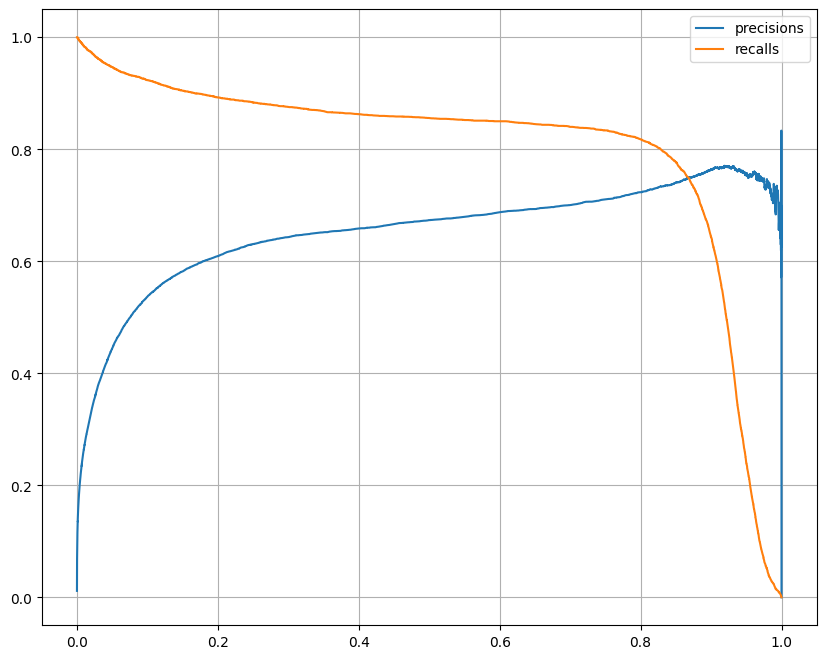

In [ ]:
plt.figure(figsize=(10, 8))
pred_ts_isRev = lgbm_clf.predict_proba(X_ts.drop(columns=['fullVisitorId', 'totals_transactionRevenue', 'is_revenue','revenue_log','date']))[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_ts_isRev, pred_ts_isRev)

plt.plot(thresholds, precisions[:len(thresholds)], label='precisions')
plt.plot(thresholds, recalls[:len(thresholds)], label='recalls')
plt.grid()
plt.legend()
plt.show()

In [ ]:
pred_ts_isRev = lgbm_clf.predict(X_ts.drop(columns=['fullVisitorId', 'totals_transactionRevenue', 'is_revenue','revenue_log','date']))
pred_ts_isRev = pred_ts_isRev.tolist()

In [ ]:
len(pred_ts_isRev)

401589

##### **B-2. Threshold 튜닝**
- 그래프를 기반으로 최적값 적용. Binarizing
- from sklearn.preprocessing import Binarizer

In [ ]:
from sklearn.preprocessing import Binarizer

In [ ]:
# X_test에 대한 확률
# 결과 리스트의 첫번째 값이 0일 확률, 두번째 값이 1일 확률

pred_proba_ts_isRev = lgbm_clf.predict_proba(X_ts.drop(columns=['fullVisitorId', 'totals_transactionRevenue', 'is_revenue','revenue_log','date']))
pred_proba_ts_isRev

array([[9.99938608e-01, 6.13922366e-05],
       [9.99993133e-01, 6.86728517e-06],
       [9.99988126e-01, 1.18744605e-05],
       ...,
       [9.99994701e-01, 5.29874098e-06],
       [9.99994013e-01, 5.98745140e-06],
       [9.99994013e-01, 5.98745140e-06]])

In [ ]:
# 분류 모델의 Precision-Recall 그래프에서 precisions, recalls 두 선이 교차하는 값인 약 0.85정도를 threshold로 설정하고 예측

binarizer = Binarizer(threshold=0.84).fit(pred_proba_ts_isRev)

# threshold가 0.38을 넘으면 1로 표현 되야 되기에 [:, 1]값을 사용
pred_ts_isRev_bin = binarizer.transform(pred_proba_ts_isRev)[:, 1]
pred_ts_isRev_bin

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# threshold로 = 0.85 로 예측한 classification_report입니다.
# # Recall 값이 소폭 상승

print(classification_report(y_ts_isRev, pred_ts_isRev_bin))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    396995
           1       0.74      0.79      0.76      4594

    accuracy                           0.99    401589
   macro avg       0.87      0.89      0.88    401589
weighted avg       0.99      0.99      0.99    401589



## 회귀 모델링

---

- 분류기에서 train_test_split을 사용하여 성능을 검증
- 회귀에서는 분류기에 전체 X데이터, 전체 y 데이터 를 가지고 분류 한 이후 회귀모델을 수행

### LGBMclassifier 회귀 전처리

#### A. 훈련 세트 기반 Fit

In [ ]:
#train
X_tr = data_tr.drop(['fullVisitorId', 'totals_transactionRevenue','revenue_log','is_revenue','date'], axis=1)
y_tr_isRev = data_tr['is_revenue']

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=400, random_state=13)
lgbm_clf.fit(X_tr, y_tr_isRev)

LGBMClassifier(n_estimators=400)

##### **A-1. 분류 모델 평가**

In [ ]:
pred_tr_isRev = lgbm_clf.predict(X_tr)

In [ ]:
# 분류기의 feature_import_clf를 상위 20개를 DataFrame화 합니다.

feature_import_clf =  list(zip(lgbm_clf.feature_name_, lgbm_clf.feature_importances_))
feature_import_clf = pd.DataFrame(feature_import_clf)
feature_import_clf.columns = ['feature', 'importance']
feature_import_clf = feature_import_clf.sort_values(by='importance', ascending=False)
feature_import_clf.head(20)

feature  importance
29          hits_appInfo.exitScreenName        1454
4                     totals_timeOnSite        1205
10                                 week         869
2                      totals_pageviews         853
1                           totals_hits         771
19  hits_contentGroup.contentGroup2_Ent         754
3              totals_sessionQualityDim         751
8                             hits_hour         663
11                              weekday         422
30       hits_appInfo.landingScreenName         407
15                     revisit_dur_time         339
16                      total_life_time         320
5                           visitNumber         318
18                            stickness         291
14                      weekdaily_visit         259
40                   hits_page.pagePath         239
43                         hits_referer         206
25               device_operatingSystem         206
9                                 month         181
28                   geoNetwork_country         122

In [ ]:
get_clf_eval(y_tr_isRev, pred_tr_isRev)

ACC       :  0.9991673178855435
Precision :  0.9569218458255535
Recall    :  0.9668508287292817
F1 score  :  0.9618607145251022
AUC score :  0.9831864782885481


In [ ]:
print(classification_report(y_tr_isRev, pred_tr_isRev))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    675913
           1       0.96      0.97      0.96      7421

    accuracy                           1.00    683334
   macro avg       0.98      0.98      0.98    683334
weighted avg       1.00      1.00      1.00    683334



---

#### B. 테스트 세트 기반 예측

##### **B-1. 분류 모델 평가 (Test set 기반)**

In [ ]:
X_ts = data_ts.drop(['fullVisitorId', 'totals_transactionRevenue','revenue_log','is_revenue','date'], axis=1)
y_ts_isRev = data_ts['is_revenue']

In [ ]:
pred_ts_isRev = lgbm_clf.predict(X_ts)

In [ ]:
# 분류기의 feature_import_clf를 상위 20개를 DataFrame화 합니다.

feature_import_clf =  list(zip(lgbm_clf.feature_name_, lgbm_clf.feature_importances_))
feature_import_clf = pd.DataFrame(feature_import_clf)
feature_import_clf.columns = ['feature', 'importance']
feature_import_clf = feature_import_clf.sort_values(by='importance', ascending=False)
feature_import_clf.head(20)

feature  importance
29          hits_appInfo.exitScreenName        1454
4                     totals_timeOnSite        1205
10                                 week         869
2                      totals_pageviews         853
1                           totals_hits         771
19  hits_contentGroup.contentGroup2_Ent         754
3              totals_sessionQualityDim         751
8                             hits_hour         663
11                              weekday         422
30       hits_appInfo.landingScreenName         407
15                     revisit_dur_time         339
16                      total_life_time         320
5                           visitNumber         318
18                            stickness         291
14                      weekdaily_visit         259
40                   hits_page.pagePath         239
43                         hits_referer         206
25               device_operatingSystem         206
9                                 month         181
28                   geoNetwork_country         122

In [ ]:
get_clf_eval(y_ts_isRev, pred_ts_isRev)

ACC       :  0.9935705410257751
Precision :  0.6705084745762712
Recall    :  0.8611232041793644
F1 score  :  0.7539546407470934
AUC score :  0.9281132085330882


In [ ]:
print(classification_report(y_ts_isRev, pred_ts_isRev))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    396995
           1       0.67      0.86      0.75      4594

    accuracy                           0.99    401589
   macro avg       0.83      0.93      0.88    401589
weighted avg       0.99      0.99      0.99    401589



---

### RandomForestRegressor 매출 예측

#### **A-a. 훈련 세트 기반 Fit (시행 1)**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
data_ts.shape, len(pred_ts_isRev)

((401589, 65), 401589)

##### **a-1. 분류기 예측에 기반한 구매자 분리**

In [ ]:
# 분류기 결과 pred_isRev 컬럼 생성하여 추가
data_tr['pred_isRev'] = pred_tr_isRev
data_tr[['is_revenue', 'pred_isRev']].value_counts()

is_revenue  pred_isRev
0           0             675590
1           1               7175
0           1                323
1           0                246
dtype: int64

In [ ]:
# pred_revenue컬럼을 이용하여 회귀분류로 갈 세션과 그렇지 않은 세션을 구분
data_tr_isRev = data_tr[data_tr['pred_isRev'] == 1].drop('pred_isRev', axis=1)
data_tr_noRev = data_tr[data_tr['pred_isRev'] == 0].drop('pred_isRev', axis=1)
data_tr_isRev.shape, data_tr_noRev.shape

((7498, 65), (675836, 65))

##### **a-2. 컬럼 선정, 훈련 및 검증**

In [ ]:
# 분류기에서 중요도가 높았던 상위 10개의 피처로 회귀 모델 훈련
coeff_top10 = feature_import_clf.head(10)['feature'].tolist()

In [ ]:
# 데이터 분리
X_tr = data_tr_isRev[coeff_top10]
y_tr_rev = data_tr_isRev['totals_transactionRevenue']
y_tr_rev = np.log1p(y_tr_rev)

X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr_rev, test_size=0.2, random_state=13)

#모델 훈련
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

#예측
pred_tr_rev = rf_reg.predict(X_test)

In [ ]:
# 추후 RFM 분석을 위해 전체 train 데이터에 대한 예측값 구함
pred_tr_rev_for_rfm = rf_reg.predict(X_tr)

##### **a-3. 미구매자와 데이터 merge**

In [ ]:
X_train.shape, X_test.shape, y_test.shape, pred_tr_rev.shape, data_tr_noRev.shape

((5998, 10), (1500, 10), (1500,), (1500,), (675836, 65))

In [ ]:
# 분류기와 회귀 결과 병합
result_clf = list(zip(np.log1p(data_tr_noRev['totals_transactionRevenue']), [0]*len(data_tr_noRev['totals_transactionRevenue'])))
result_reg = list(zip(y_test, pred_tr_rev))

y_tr_merged = result_clf + result_reg
y_tr_rev_result, pred_tr_rev_result = zip(*y_tr_merged)

##### **a-4. 회귀모델 평가**

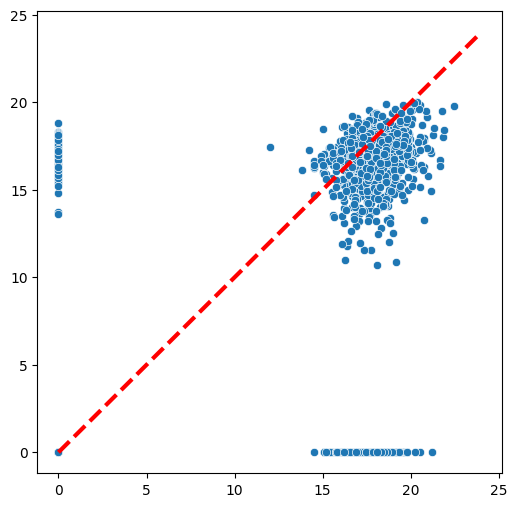

In [ ]:
# 실제값, 예측값에 대한 시각화 입니다.

plt.figure(figsize=(6,6))

sns.scatterplot(x=y_tr_rev_result, y=pred_tr_rev_result)
y = y_tr_rev
plt.plot([int(y.min()), int(y.max() + 1)], [int(y.min()), int(y.max() + 1)], 'r', ls='dashed', lw=3)


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_tr_rev_result, pred_tr_rev_result)
rmse = np.sqrt(mse)
print('mse : ', mse)
print('rmse : ', rmse)


mse :  0.144973727900951
rmse :  0.3807541567743562


#### **A-b. 테스트 세트 기반 Pred (시행 1)**

##### **b-1. 회귀모델 예측 및 평가**

In [ ]:
data_ts['pred_isRev'] = pred_ts_isRev
print(data_ts[['is_revenue', 'pred_isRev']].value_counts())

data_ts_isRev = data_ts[data_ts['pred_isRev'] == 1].drop('pred_isRev', axis=1)
data_ts_noRev = data_ts[data_ts['pred_isRev'] == 0].drop('pred_isRev', axis=1)
data_ts_isRev.shape, data_ts_noRev.shape

is_revenue  pred_isRev
0           0             395051
1           1               3956
0           1               1944
1           0                638
dtype: int64


((5900, 65), (395689, 65))

In [ ]:
X_ts = data_ts_isRev[coeff_top10]
y_ts_rev = data_ts_isRev['totals_transactionRevenue']
y_ts_rev = np.log1p(y_ts_rev)

pred_ts_rev = rf_reg.predict(X_ts)

In [ ]:
# 추후 RFM 분석을 위해 test 데이터에 대한 예측값 저장
pred_ts_rev_for_rfm = rf_reg.predict(X_ts)

##### **b-2. 미구매자 데이터 merge**

In [ ]:
result_clf = list(zip(np.log1p(data_ts_noRev['totals_transactionRevenue']), [0]*len(data_ts_noRev['totals_transactionRevenue'])))
result_reg = list(zip(y_ts_rev, pred_ts_rev))

y_ts_merged = result_clf + result_reg
y_ts_rev_result, pred_ts_rev_result = zip(*y_ts_merged)

##### b-3. **회귀모델 평가**

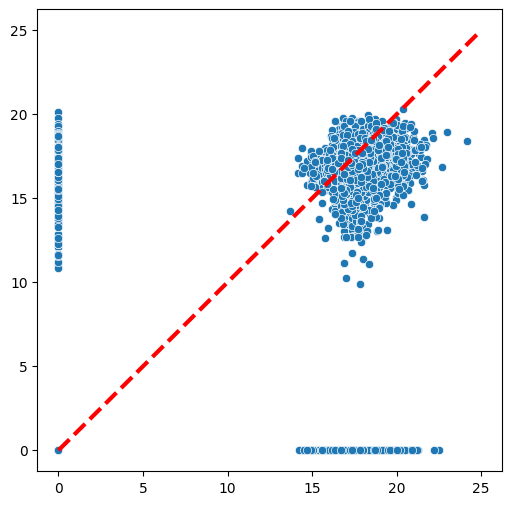

In [ ]:
# 실제값, 예측값에 대한 시각화

plt.figure(figsize=(6,6))

sns.scatterplot(x=y_ts_rev_result, y=pred_ts_rev_result)
y = y_ts_rev
plt.plot([int(y.min()), int(y.max() + 1)], [int(y.min()), int(y.max() + 1)], 'r', ls='dashed', lw=3)

In [ ]:
mse = mean_squared_error(y_ts_rev_result, pred_ts_rev_result)
rmse = np.sqrt(mse)
print('mse : ', mse)
print('rmse : ', rmse)


mse :  1.8651305311208322
rmse :  1.3656978183774156


---

#RFM 고객 분류

## 훈련세트 기반 RFM 고객 분류

- R (Recency) : 고객이 마지막으로 구매 한 시간입니다. 고객이 제품을 구입 한 가장 최근 날짜를 나타냅니다.

- F (Frequency) : 고객이 구매 한 횟수입니다. 고객이 제품을 구매 한 총 빈도를 나타냅니다.

- M (Monetary) : 고객이 지출 한 총 금액입니다. 고객이 제품을 구매할 때 지출 한 총 금액을 나타냅니다.

### A. RFM 스코어링

In [ ]:
# pred_tr_rev_for_rfm
data_tr_isRev['pred_revenue'] = pred_tr_rev_for_rfm

In [ ]:
data_ts_isRev['date'] = pd.to_datetime(data_ts_isRev['date'], format='%Y-%m-%d')

In [ ]:
data_tr_isRev.shape

(7457, 66)

In [ ]:
# August 1st 2016 to April 30th 2018
reference_date = pd.to_datetime('2016-08-01')
str(reference_date.date())

'2016-08-01'

#### R

- 고객이 마지막으로 구매한 시간을 찾아야 한다.
- Id를 기준으로 중복검사를 해서 date가 가장 늦은값을 추려내야한다.

In [ ]:
# 'date' 컬럼 기준으로 오름차순 정렬 후 중복값 마지막값만 남기고(최신 일자) Drop)
data_tr_rfm = data_tr_isRev.sort_values(by='date', ascending=True)
data_tr_rfm = data_tr_rfm.drop_duplicates('fullVisitorId', keep='last')
data_tr_rfm.head()

fullVisitorId  hits_hitNumber  totals_hits  totals_pageviews  \
551913  8844262168616364981               1          229               103   
109398  6569605994631186947               1           36                27   
449710  2976178532750719771               1           35                26   
500064  4993485206334150199               1           16                13   
20111   6452285658468801695               1           83                60   

        totals_sessionQualityDim  totals_timeOnSite  \
551913                         0               2434   
109398                         0                809   
449710                         0                538   
500064                         0                571   
20111                          0                681   

        totals_transactionRevenue  visitNumber  totals_bounces  \
551913                  111910000            3               0   
109398                  140560000            3               0   
449710                   15930000            2               0   
500064                   16990000            1               0   
20111                    31990000            1               0   

        totals_newVisits  ...  hits_isExit  hits_isInteraction  \
551913                 0  ...            1                   0   
109398                 0  ...            1                   0   
449710                 0  ...            1                   0   
500064                 1  ...            1                   0   
20111                  1  ...            1                   0   

        hits_promotionActionInfo.promoIsView  \
551913                                     1   
109398                                     1   
449710                                     1   
500064                                     1   
20111                                      1   

        hits_promotionActionInfo.promoIsClick  trafficSource_isTrueDirect  \
551913                                      1                           0   
109398                                      1                           0   
449710                                      1                           0   
500064                                      1                           1   
20111                                       1                           0   

        trafficSource_adwordsClickInfo.isVideoAd  revenue_log        date  \
551913                                         1    18.533205  2016-08-01   
109398                                         1    18.761145  2016-08-01   
449710                                         1    16.583715  2016-08-01   
500064                                         1    16.648136  2016-08-01   
20111                                          1    17.280933  2016-08-01   

        pred_revenue  pred_revenue_$  
551913     18.485356          106.68  
109398     15.229841            4.11  
449710     16.293023           11.91  
500064     16.987797           23.86  
20111      16.638482           16.83  

[5 rows x 67 columns]

- 마지막으로 구매한 시간
    - 세션별 'date' 컬럼 - 기준 날짜
    - 최근에 구매한 세션일 수록 값이 크게 나올 것 -> 점수화 용이하게 하기 위함

In [ ]:
data_tr_rfm['date'] = pd.to_datetime(data_tr_rfm['date'])
data_tr_rfm['date'].info()

<class 'pandas.core.series.Series'>
Int64Index: 6969 entries, 551913 to 331637
Series name: date
Non-Null Count  Dtype         
--------------  -----         
6969 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 108.9 KB


In [ ]:
data_tr_rfm['Recency'] = data_tr_rfm['date'] - reference_date

In [ ]:
# Recency 컬럼의 최대 최소
data_tr_rfm['Recency'].max(), data_tr_rfm['Recency'].min()

(Timedelta('637 days 00:00:00'), Timedelta('0 days 00:00:00'))

In [ ]:
data_tr_rfm = data_tr_rfm.set_index('fullVisitorId')
data_tr_rfm.head()

hits_hitNumber  totals_hits  totals_pageviews  \
fullVisitorId                                                        
8844262168616364981               1          229               103   
6569605994631186947               1           36                27   
2976178532750719771               1           35                26   
4993485206334150199               1           16                13   
6452285658468801695               1           83                60   

                     totals_sessionQualityDim  totals_timeOnSite  \
fullVisitorId                                                      
8844262168616364981                         0               2434   
6569605994631186947                         0                809   
2976178532750719771                         0                538   
4993485206334150199                         0                571   
6452285658468801695                         0                681   

                     totals_transactionRevenue  visitNumber  totals_bounces  \
fullVisitorId                                                                 
8844262168616364981                  111910000            3               0   
6569605994631186947                  140560000            3               0   
2976178532750719771                   15930000            2               0   
4993485206334150199                   16990000            1               0   
6452285658468801695                   31990000            1               0   

                     totals_newVisits  hits_hour  ...  hits_isInteraction  \
fullVisitorId                                     ...                       
8844262168616364981                 0         11  ...                   0   
6569605994631186947                 0         13  ...                   0   
2976178532750719771                 0          9  ...                   0   
4993485206334150199                 1         20  ...                   0   
6452285658468801695                 1         12  ...                   0   

                     hits_promotionActionInfo.promoIsView  \
fullVisitorId                                               
8844262168616364981                                     1   
6569605994631186947                                     1   
2976178532750719771                                     1   
4993485206334150199                                     1   
6452285658468801695                                     1   

                     hits_promotionActionInfo.promoIsClick  \
fullVisitorId                                                
8844262168616364981                                      1   
6569605994631186947                                      1   
2976178532750719771                                      1   
4993485206334150199                                      1   
6452285658468801695                                      1   

                     trafficSource_isTrueDirect  \
fullVisitorId                                     
8844262168616364981                           0   
6569605994631186947                           0   
2976178532750719771                           0   
4993485206334150199                           1   
6452285658468801695                           0   

                     trafficSource_adwordsClickInfo.isVideoAd  revenue_log  \
fullVisitorId                                                                
8844262168616364981                                         1    18.533205   
6569605994631186947                                         1    18.761145   
2976178532750719771                                         1    16.583715   
4993485206334150199                                         1    16.648136   
6452285658468801695                                         1    17.280933   

                          date  pred_revenue  pred_revenue_$  Recency  
fullVisitorId                                                          
8844262168616364981 2016-08-01     18.485356   

#### F

- 구매를 했다? -> revenue > 0
- 고객이 구매를 한 횟수 -> groupby & count


In [ ]:
raw_f = pd.DataFrame(data_tr_isRev.groupby('fullVisitorId').count()['hits_hitNumber'])
raw_f.columns = ['Frequency']
raw_f[raw_f['Frequency'] == 16]

Frequency
fullVisitorId                 
7813149961404844386         16

- raw_f의 fullVisitorId에 포함되지 않는 fullVisitorId -> Frequency = 0

In [ ]:
from tqdm import tqdm

In [ ]:
raw_f_index = raw_f.index.tolist()

In [ ]:
data_tr_rfm['Frequency'] = np.nan

for index in tqdm(raw_f_index):
    data_tr_rfm.loc[index, 'Frequency'] = raw_f['Frequency'].loc[index]

100%|██████████| 6969/6969 [00:00<00:00, 9369.98it/s]


In [ ]:
data_tr_rfm['Frequency'].value_counts()

1.0     6605
2.0      296
3.0       48
4.0       10
6.0        3
5.0        2
7.0        2
16.0       1
10.0       1
8.0        1
Name: Frequency, dtype: int64

In [ ]:
data_tr_rfm[data_tr_rfm['Frequency'] == 16]

hits_hitNumber  totals_hits  totals_pageviews  \
fullVisitorId                                                        
7813149961404844386               1           24                17   

                     totals_sessionQualityDim  totals_timeOnSite  \
fullVisitorId                                                      
7813149961404844386                         0                847   

                     totals_transactionRevenue  visitNumber  totals_bounces  \
fullVisitorId                                                                 
7813149961404844386                  123250000          130               0   

                     totals_newVisits  hits_hour  ...  \
fullVisitorId                                     ...   
7813149961404844386                 0         13  ...   

                     hits_promotionActionInfo.promoIsView  \
fullVisitorId                                               
7813149961404844386                                     1   

                     hits_promotionActionInfo.promoIsClick  \
fullVisitorId                                                
7813149961404844386                                      1   

                     trafficSource_isTrueDirect  \
fullVisitorId                                     
7813149961404844386                           0   

                     trafficSource_adwordsClickInfo.isVideoAd  revenue_log  \
fullVisitorId                                                                
7813149961404844386                                         1    18.629725   

                          date  pred_revenue  pred_revenue_$  Recency  \
fullVisitorId                                                           
7813149961404844386 2017-05-01     18.430551          100.99 273 days   

                     Frequency  
fullVisitorId                   
7813149961404844386       16.0  

[1 rows x 68 columns]

#### M

- 고객이 지출한 총 금액 -> groupby -> sum
    - $ scale, log scale 둘다 일단 계산해서 이쁘게 나오는 거 사용

- 단순 로그 예측값을 그냥 더한뒤 풀어버리면 어마어마하게 큰 숫자가 발생한다.
- 에측 로그값을 $로 변환뒤 더한 후 다시 로그를 씌워야 한다.

In [ ]:
data_tr_isRev['pred_revenue_$'] = round((np.expm1(data_tr_isRev['pred_revenue']) / 1000000), 2)

In [ ]:
raw_m = data_tr_isRev.groupby('fullVisitorId').sum()[['totals_transactionRevenue', 'revenue_log', 'pred_revenue_$']]
raw_m['totals_transactionRevenue'] = raw_m['totals_transactionRevenue'] / 1000000
raw_m.isnull().sum()

totals_transactionRevenue    0
revenue_log                  0
pred_revenue_$               0
dtype: int64

In [ ]:
raw_m_index = raw_m.index.tolist()

In [ ]:
# data_tr_rfm['Monetary_$'] = np.nan
# data_tr_rfm['Monetary_log'] = np.nan

# for index in tqdm(raw_m_index):
#     data_tr_rfm.loc[index, 'Monetary_$'] = raw_m['totals_transactionRevenue'].loc[index]
#     data_tr_rfm.loc[index, 'Monetary_log'] = raw_m['revenue_log'].loc[index]

In [ ]:
data_tr_rfm['pred_revenue'] = np.log1p(raw_m['pred_revenue_$'] * 1000000)
data_tr_rfm['pred_revenue_$'] = raw_m['pred_revenue_$']

In [ ]:
# data_tr_rfm = data_tr_rfm[['Recency', 'Frequency', 'Monetary_$', 'Monetary_log']]
data_tr_rfm = data_tr_rfm[['Recency', 'Frequency', 'pred_revenue', 'pred_revenue_$']]
data_tr_rfm['Recency'] = data_tr_rfm['Recency'].astype('str')
data_tr_rfm['Recency'] = data_tr_rfm['Recency'].str[:-5]
data_tr_rfm['Recency'] = data_tr_rfm['Recency'].astype('int')

In [ ]:
data_tr_rfm['Frequency'] = data_tr_rfm['Frequency'].astype('int')
data_tr_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6969 entries, 8844262168616364981 to 5580128322514918813
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Recency         6969 non-null   int64  
 1   Frequency       6969 non-null   int64  
 2   pred_revenue    6969 non-null   float64
 3   pred_revenue_$  6969 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 530.3+ KB


In [ ]:
# data_tr_rfm.sort_values(by='pred_revenue_$', ascending=False).to_csv('./for_chech.csv', encoding='utf-8')
data_tr_rfm

Recency  Frequency  pred_revenue  pred_revenue_$
fullVisitorId                                                        
8844262168616364981        0          1     18.485344          106.68
6569605994631186947        0          1     15.228934            4.11
2976178532750719771        0          1     16.292889           11.91
4993485206334150199        0          1     16.987714           23.86
6452285658468801695        0          1     16.638674           16.83
...                      ...        ...           ...             ...
5185999036083981946      637          1     16.189486           10.74
7491953604004778859      637          1     20.058492          514.39
5913788785832024191      637          1      0.000000            0.00
0390132315121818780      637          1     16.360257           12.74
5580128322514918813      637          1      0.000000            0.00

[6969 rows x 4 columns]

In [ ]:
data_tr_rfm.to_pickle('/content/drive/MyDrive/ds_study/team_notebook/data_tr_rfm.pickle')

---

#### 스케일링

In [ ]:
from matplotlib.gridspec import GridSpec

- normal

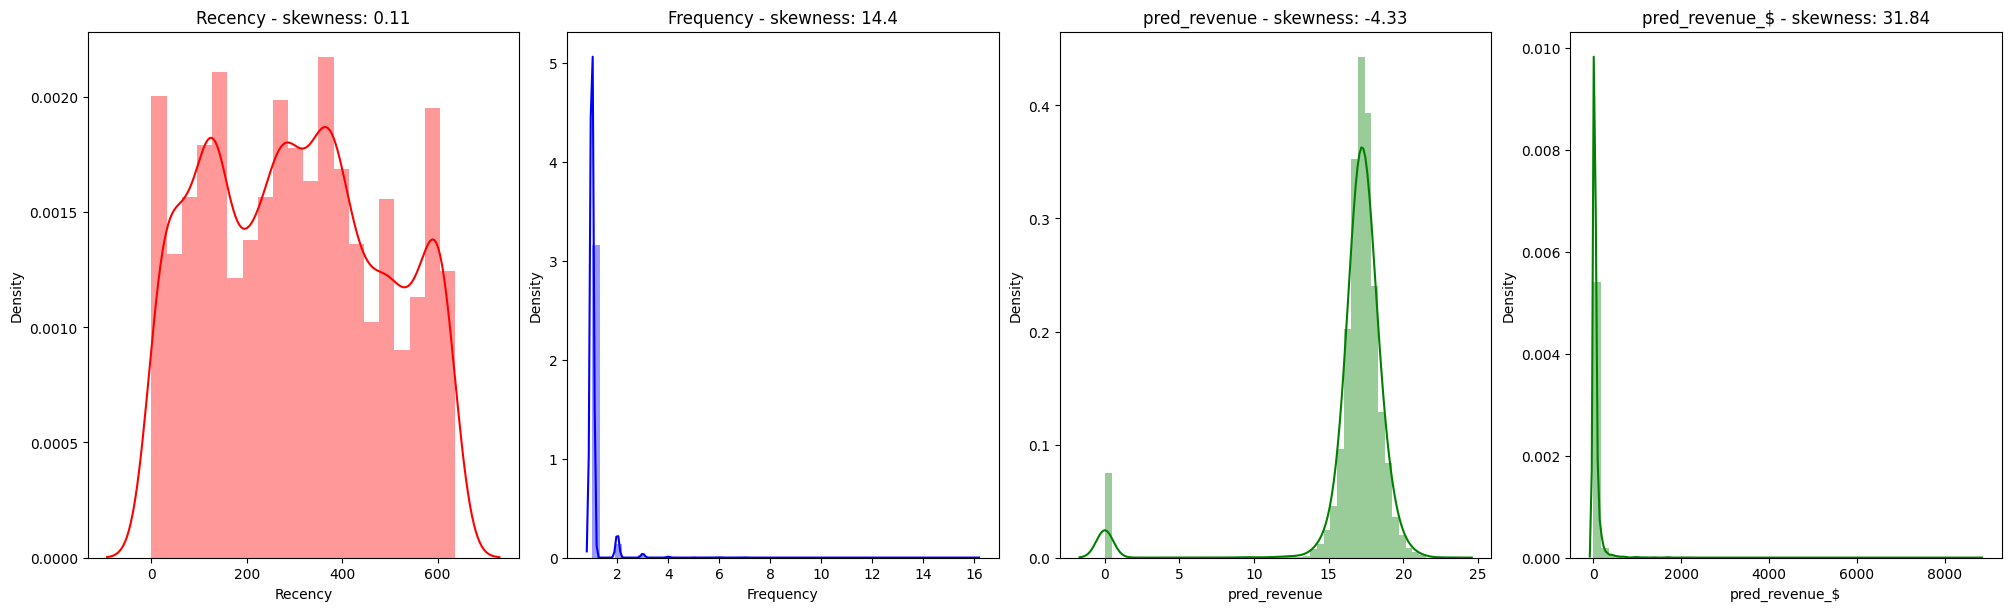

In [ ]:
# Graph
i = 0
fig = plt.figure(constrained_layout = True,figsize=(20,6))
gs = GridSpec(1,4,figure=fig)

col = ['red','blue','green', 'green']
for var in list(data_tr_rfm.columns):
  plt.subplot(gs[0,i])
  sns.distplot(data_tr_rfm[var],color=col[i])
  plt.title(var + ' - ' + 'skewness' + ': ' + round(data_tr_rfm[var].skew(),2).astype(str))
  i= i+1

- Log transform

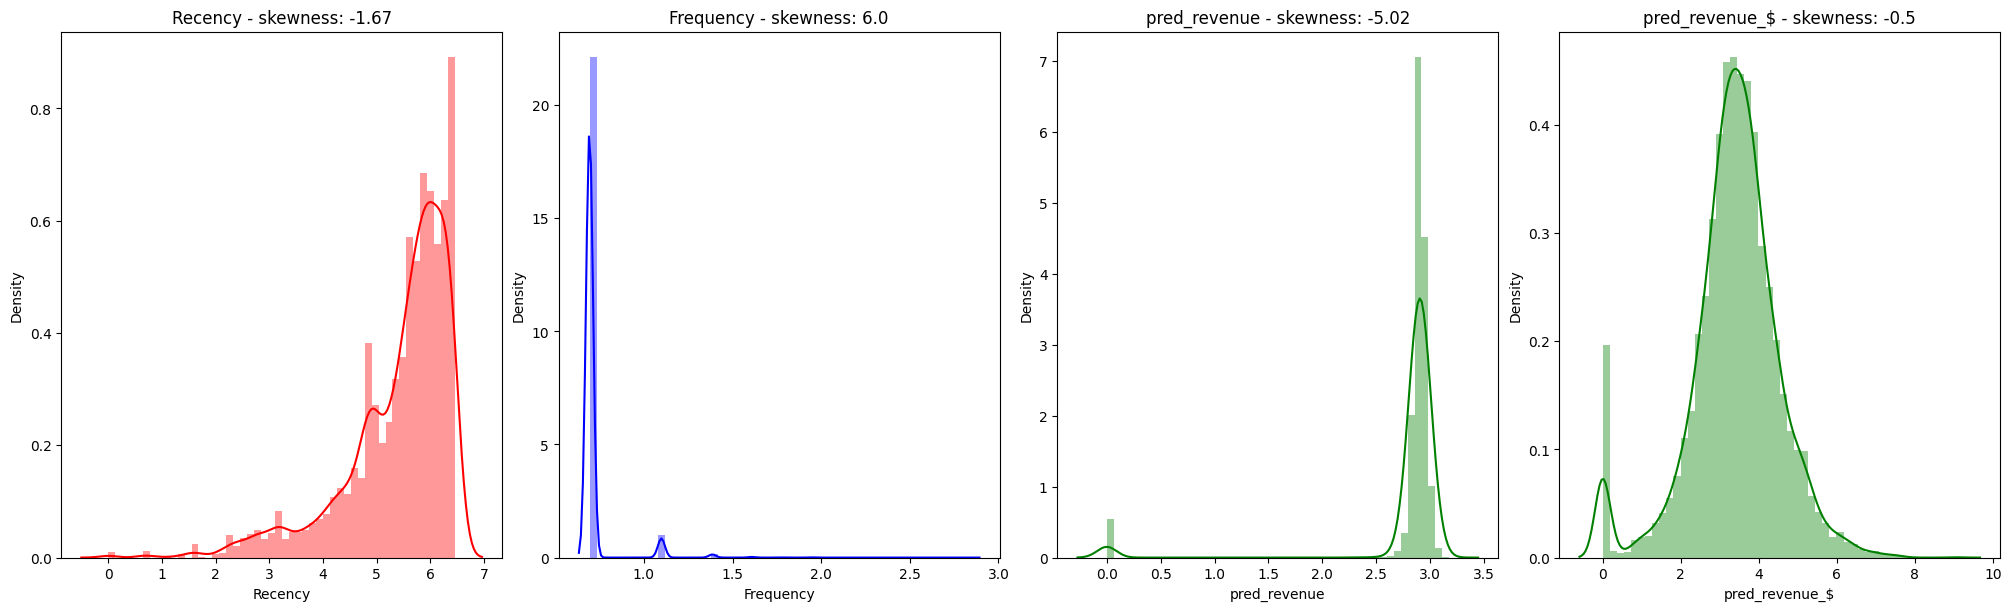

In [ ]:
# Graph
i = 0
fig = plt.figure(constrained_layout = True,figsize=(20,6))
gs = GridSpec(1,4,figure=fig)

col = ['red','blue','green', 'green']
for var in list(data_tr_rfm.columns):
  plt.subplot(gs[0,i])
  sns.distplot(np.log1p(data_tr_rfm[var]),color=col[i])
  plt.title(var + ' - ' + 'skewness' + ': ' + round(np.log1p(data_tr_rfm[var]).skew(),2).astype(str))
  i= i+1

- Squared root transfrom

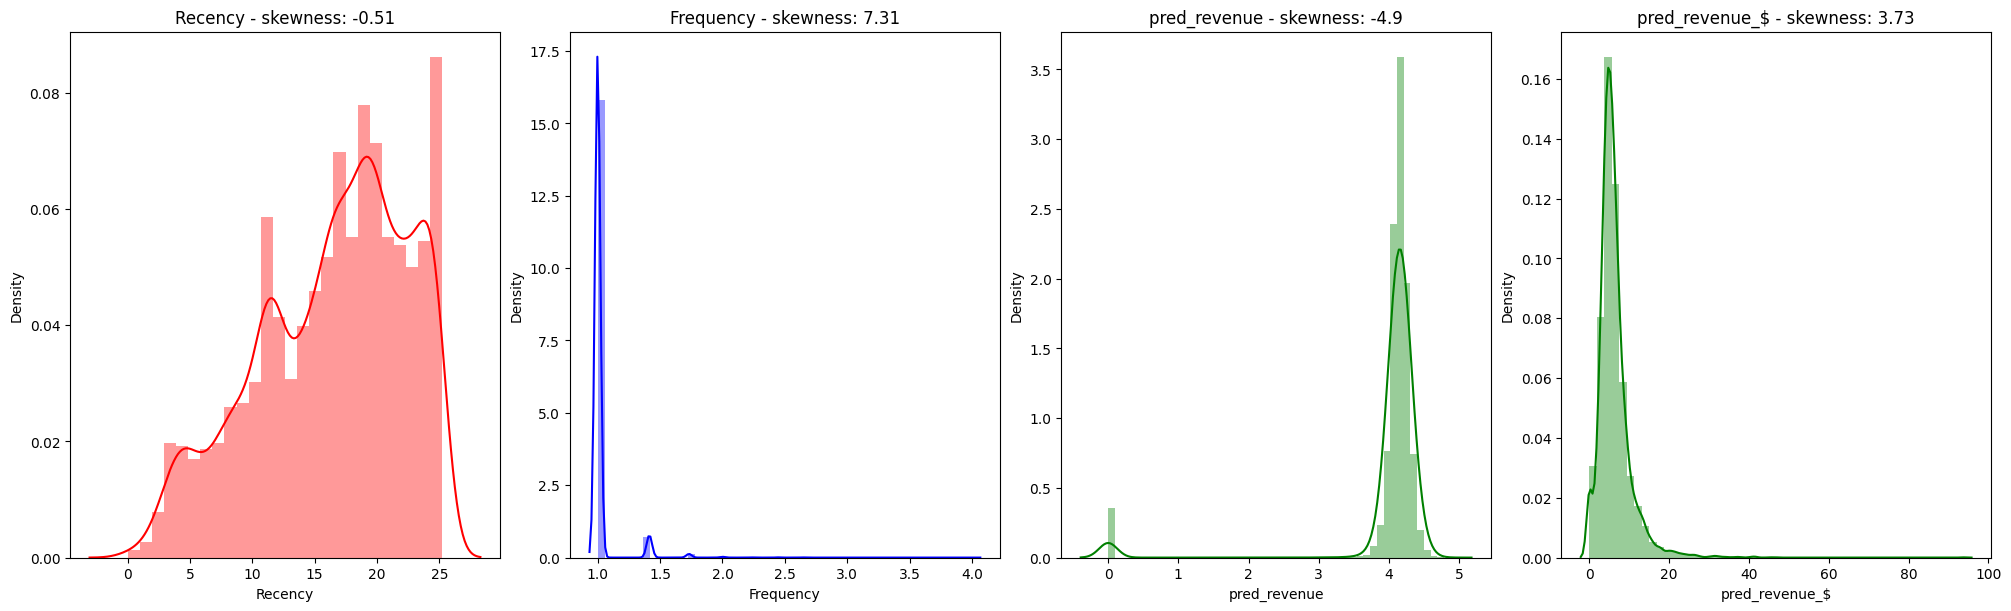

In [ ]:
# Graph
i = 0
fig = plt.figure(constrained_layout = True,figsize=(20,6))
gs = GridSpec(1,4,figure=fig)

col = ['red','blue','green', 'green']
for var in list(data_tr_rfm.columns):
  plt.subplot(gs[0,i])
  sns.distplot(np.sqrt(data_tr_rfm[var]),color=col[i])
  plt.title(var + ' - ' + 'skewness' + ': ' + round(np.sqrt(data_tr_rfm[var]).skew(),2).astype(str))
  i= i+1

- Box-Cox Trnasform

In [ ]:
from scipy.stats import boxcox

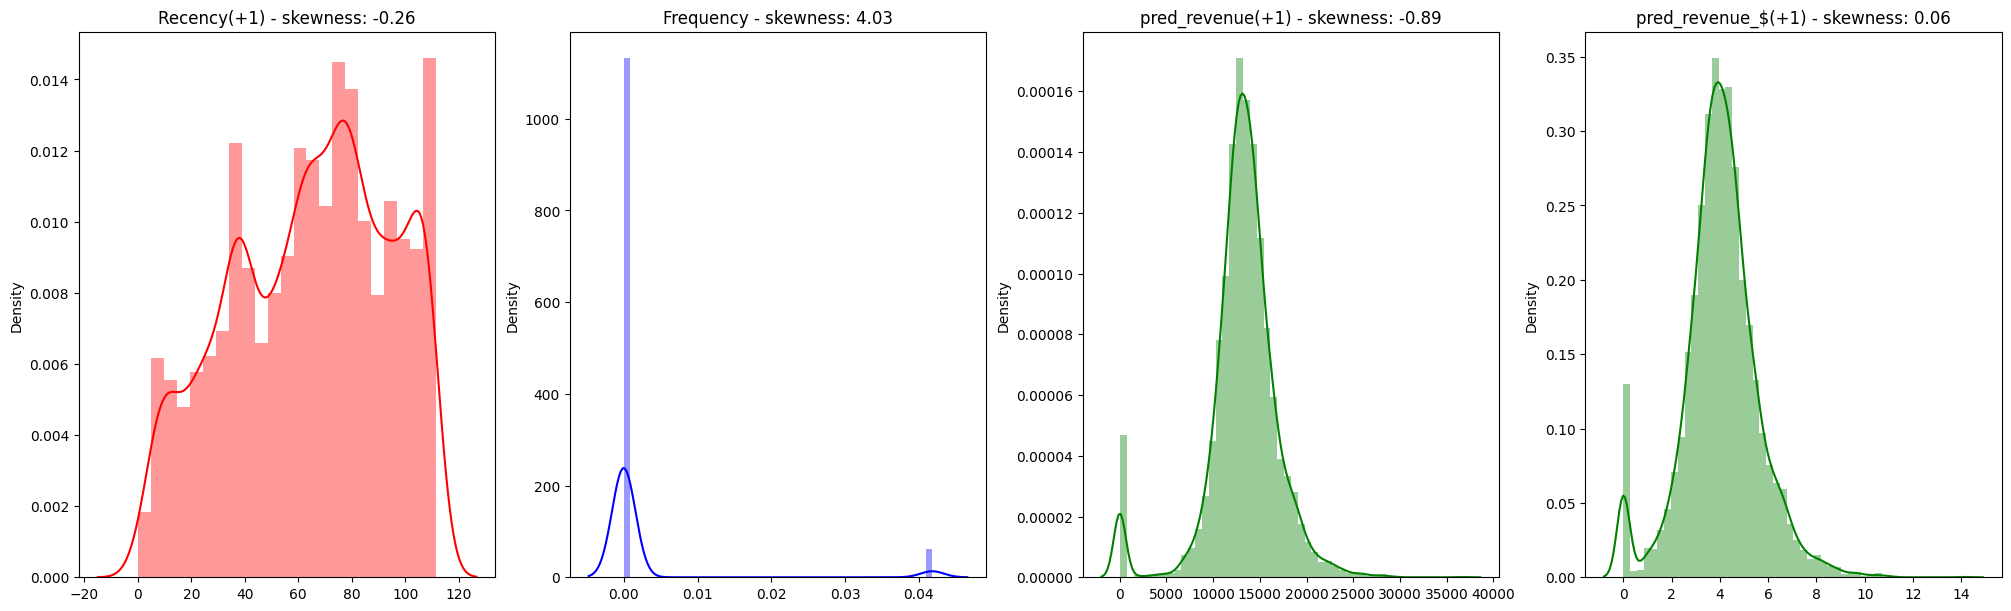

In [ ]:
# Graph
i = 0
fig = plt.figure(constrained_layout = True,figsize=(20,6))
gs = GridSpec(1,4,figure=fig)

col = ['red','blue','green', 'green']
for var in list(data_tr_rfm.columns):
  plt.subplot(gs[0,i])
  try:
    sns.distplot(pd.Series(boxcox(data_tr_rfm[var])[0]),color=col[i])  
    plt.title(var + ' - ' + 'skewness' + ': ' + str(round(pd.Series(boxcox(data_tr_rfm[var])[0]).skew(),2)))
  except:
    sns.distplot(pd.Series(boxcox(data_tr_rfm[var]+1)[0]),color=col[i]) 
    plt.title(var + '(+1) - ' + 'skewness' + ': ' + str(round(pd.Series(boxcox(data_tr_rfm[var] + 1)[0]).skew(),2)))
  i= i+1

- Recency : normal을 기준으로 균등하게 분리하는 것이 좋아보임
- Frequency : 어느 변환을 하더라도 분산이 매우 심함, 유니크 값이 적기도 하고 그냥 균등하게 분리하는게 어떤지
- Monetary_$, Monetary_log : Monetary_$가 모든 변환에서 우수해보임, Monetary_$중에서 boxcox변환보다 log변환이 분산이 크게 나와서 분리하기 좋아보임

---

체크포인트

In [ ]:
data_tr_rfm = pd.read_pickle('/content/drive/MyDrive/ds_study/team_notebook/data_tr_rfm.pickle')

#### Scoring

- 각 구간별 4단계 1, 2, 3, 4으로 구분해 보자

##### R

In [ ]:
data_tr_rfm['Recency'].mean(), data_tr_rfm['Recency'].median()

(304.27277945185824, 299.0)

In [ ]:
r_quantile = [np.quantile(data_tr_rfm['Recency'], 0.25), np.quantile(data_tr_rfm['Recency'], 0.5), np.quantile(data_tr_rfm['Recency'], 0.75)]
r_quantile

[139.0, 299.0, 445.0]

In [ ]:
data_tr_rfm['Frequency'].min(), data_tr_rfm['Frequency'].max()
section = (data_tr_rfm['Frequency'].max() - data_tr_rfm['Frequency'].min()) / 4
data_tr_rfm['Frequency'].min() + section, data_tr_rfm['Frequency'].min() + 2*section, data_tr_rfm['Frequency'].min() + 3*section

(4.75, 8.5, 12.25)

In [ ]:
def quantile_scoring(df_raw: pd.core.frame.DataFrame, column, log=False):
    import copy
    import numpy as np
    df = copy.copy(df_raw)
    if not log:
        quantile_25 = np.quantile(df[column], 0.25)
        quantile_50 = np.quantile(df[column], 0.5)
        quantile_75 = np.quantile(df[column], 0.75)

        for i, v in df.iterrows():
            if v[column] < quantile_25:
                df[column].loc[i] = 1
            if quantile_25 <= v[column] < quantile_50:
                df[column].loc[i] = 2
            if quantile_50 <= v[column] < quantile_75:
                df[column].loc[i] = 3
            if quantile_75 <= v[column]:
                df[column].loc[i] = 4

        return df[column]
    
    if log:
        quantile_25 = np.quantile(np.log1p(df[column]), 0.25)
        quantile_50 = np.quantile(np.log1p(df[column]), 0.5)
        quantile_75 = np.quantile(np.log1p(df[column]), 0.75)

        for i, v in df.iterrows():
            if np.log1p(v[column]) < quantile_25:
                df[column].loc[i] = 1
            if quantile_25 <= np.log1p(v[column]) < quantile_50:
                df[column].loc[i] = 2
            if quantile_50 <= np.log1p(v[column]) < quantile_75:
                df[column].loc[i] = 3
            if quantile_75 <= np.log1p(v[column]):
                df[column].loc[i] = 4

        return df[column]
    
##############################################################
def minmax_scoring(df_raw: pd.core.frame.DataFrame, column):
    import copy
    import numpy as np
    df = copy.copy(df_raw)

    section = (df[column].max() - df[column].min()) / 4
    section_1 =  df[column].min() + section
    section_2 =  section_1 + section
    section_3 =  section_2 + section

    for i, v in df.iterrows():
        if v[column] < section_1:
            df[column].loc[i] = 1
        if section_1 <= v[column] < section_2:
            df[column].loc[i] = 2
        if section_2 <= v[column] < section_3:
            df[column].loc[i] = 3
        if section_3 <= v[column]:
            df[column].loc[i] = 4

    return df[column]


In [ ]:
data_tr_rfm

Recency  Frequency  pred_revenue  pred_revenue_$
fullVisitorId                                                        
8844262168616364981        0          1     18.485344          106.68
6569605994631186947        0          1     15.228934            4.11
2976178532750719771        0          1     16.292889           11.91
4993485206334150199        0          1     16.987714           23.86
6452285658468801695        0          1     16.638674           16.83
...                      ...        ...           ...             ...
5185999036083981946      637          1     16.189486           10.74
7491953604004778859      637          1     20.058492          514.39
5913788785832024191      637          1      0.000000            0.00
0390132315121818780      637          1     16.360257           12.74
5580128322514918813      637          1      0.000000            0.00

[6969 rows x 4 columns]

In [ ]:
data_tr_rfm['Recency'] = quantile_scoring(data_tr_rfm, 'Recency')
data_tr_rfm['Frequency'] = minmax_scoring(data_tr_rfm, 'Frequency')
data_tr_rfm['pred_revenue_$'] = quantile_scoring(data_tr_rfm, 'pred_revenue_$', log=True)

In [ ]:
data_tr_rfm = data_tr_rfm[['Recency', 'Frequency', 'pred_revenue_$']]
data_tr_rfm = data_tr_rfm.astype('int')
data_tr_rfm

Recency  Frequency  pred_revenue_$
fullVisitorId                                          
8844262168616364981        1          1               4
6569605994631186947        1          1               1
2976178532750719771        1          1               1
4993485206334150199        1          1               2
6452285658468801695        1          1               2
...                      ...        ...             ...
5185999036083981946        4          1               1
7491953604004778859        4          1               4
5913788785832024191        4          1               1
0390132315121818780        4          1               1
5580128322514918813        4          1               1

[6969 rows x 3 columns]

In [ ]:
pd.DataFrame(data_tr_rfm.value_counts())

0
Recency Frequency pred_revenue_$     
4       1         1               559
1       1         4               528
                  3               498
4       1         2               454
3       1         1               449
2       1         2               446
                  4               437
3       1         2               435
2       1         3               431
                  1               430
3       1         4               428
                  3               426
1       1         2               406
4       1         3               388
                  4               340
1       1         1               304
4       2         4                 3
3       2         4                 2
1       2         4                 2
3       3         4                 1
2       4         4                 1
        2         4                 1

---


#### 총합 점수 및 가중치 찾기

##### 총합 점수

In [ ]:
data_tr_rfm['Total'] = np.nan
data_tr_rfm['Total'] = data_tr_rfm['Recency'] + data_tr_rfm['Frequency'] + data_tr_rfm['pred_revenue_$']

- RFM Total Score의 분포

<function matplotlib.pyplot.show(close=None, block=None)>

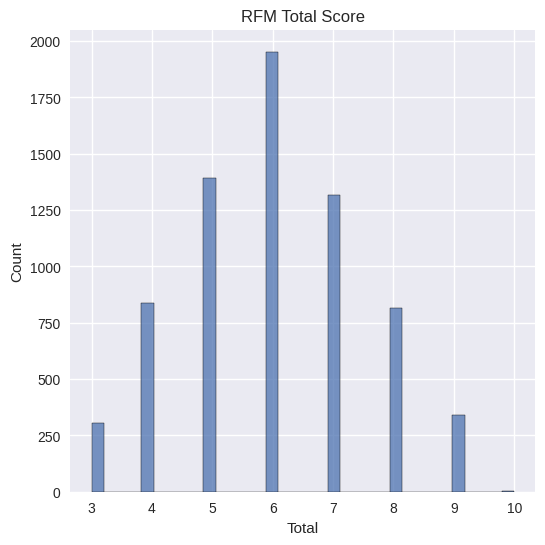

In [ ]:
# Graph
plt.figure(figsize=(6, 6))
plt.style.use('seaborn')
sns.histplot(data_tr_rfm['Total'])
plt.title('RFM Total Score')
plt.show

In [ ]:
import plotly.express as px
rfm_3d = pd.DataFrame(data_tr_rfm.value_counts()).reset_index()
rfm_3d.columns = ['Recency', 'Frequency', 'pred_revenue_$', 'Total', 'Count']
rfm_3d['for_Size'] = 1 / rfm_3d['Total']

In [ ]:
#종합 점수가 원의 사이즈, 컬러가 해당하는 id 개수
px.scatter_3d(rfm_3d, x='Recency', y='Frequency', z='pred_revenue_$', color='Count', size='for_Size', opacity=0.8) 

In [ ]:
results = pd.DataFrame(data_tr_rfm.groupby('Total').count()['Recency'])
results.columns = ['Count']
results

Count
Total       
3        304
4        836
5       1393
6       1953
7       1319
8        817
9        342
10         5

##### 가중치 찾기

- 현재 데이터 상으로는 Total의 범위 : 3~10 8구간 
    - 8구간의 20% -> 2+ 6.4 = 8.4점이상
- 나올수 있는 범위 3 (1+ 1+ 1) ~ 12 (4+ 4+ 4)

In [ ]:
data_tr_rfm['$'] = raw_m['pred_revenue_$']
data_tr_rfm = data_tr_rfm[['Recency', 'Frequency', 'pred_revenue_$', '$', 'Total']]
data_tr_rfm

Recency  Frequency  pred_revenue_$       $  Total
fullVisitorId                                                         
8844262168616364981        1          1               4  106.68      6
6569605994631186947        1          1               1    4.11      3
2976178532750719771        1          1               1   11.91      3
4993485206334150199        1          1               2   23.86      4
6452285658468801695        1          1               2   16.83      4
...                      ...        ...             ...     ...    ...
5185999036083981946        4          1               1   10.74      6
7491953604004778859        4          1               4  514.39      9
5913788785832024191        4          1               1    0.00      6
0390132315121818780        4          1               1   12.74      6
5580128322514918813        4          1               1    0.00      6

[6969 rows x 5 columns]

In [ ]:
# 점수별 매출 총합
results = pd.DataFrame(data_tr_rfm.groupby('Total').sum()['$'])

In [ ]:
# 점수별 매출 평균
results_mean = pd.DataFrame(data_tr_rfm.groupby('Total').mean()['$'])

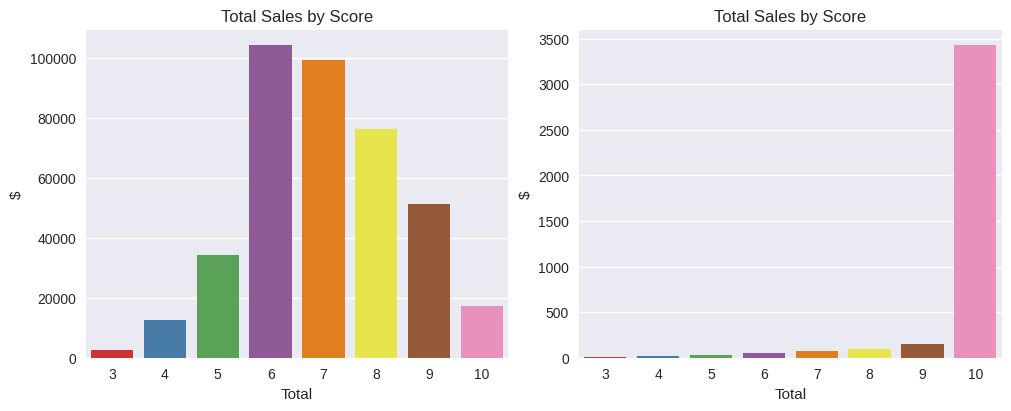

In [ ]:
# Graph
fig = plt.figure(constrained_layout = True,figsize=(10,4))
gs = GridSpec(1,2,figure=fig)

plt.subplot(gs[0,0])
sns.barplot(results, x=results.index, y=results['$'], palette='Set1')
plt.title('Total Sales by Score')

plt.subplot(gs[0,1])
sns.barplot(results_mean, x=results_mean.index, y=results_mean['$'], palette='Set1')
plt.title('Total Sales by Score')
plt.show()

- RFM 점수의 상위 20%

In [ ]:
vip_rfm = np.quantile(data_tr_rfm['Total'], 0.8) # 7.0
vip_rfm

7.0

- RFM 점수의 상위 20%의 매출 비율

In [ ]:
str(round(((data_tr_rfm['$'][data_tr_rfm['Total'] >= vip_rfm].sum() /data_tr_rfm['$'].sum()) * 100), 2)) + '%'

'61.32%'

- 매출의 상위 20%

In [ ]:
vip_dollor =np.quantile(data_tr_rfm['$'], 0.8) # 65.79 $

---

- 파레토 법칙에 따른 RFM모델의 가중치 선정
    - RFM 점수 상위 20% 고객이 전체의 80%의 매출을 담당한다고 가정

    - 가중치를 모두 더해서 1이 되는 경우의 수를 계산해서 RFM 점수 계산
    - RFM 점수의 상위 20% 분류
    - RFM 점수 상위 20%의 매출 비율 확인
    - 80% 값이 넘어가면 Stop

##### <span style='color: #2D3748; background-color: #fff5b1'> **숫자 잘못만지면 커널 죽음!!!!!**</span>

In [ ]:
import itertools

# 가능한 모든 조합 생성
combinations = list(itertools.product(np.round((np.linspace(0, 1, 300)), 3), repeat=3))

# x + y + z = 1인 경우 필터링
weights = list(set([comb for comb in combinations if sum(comb) == 1]))

print(weights)

[(0.281, 0.334, 0.385), (0.224, 0.361, 0.415), (0.572, 0.401, 0.027), (0.241, 0.033, 0.726), (0.435, 0.254, 0.311), (0.197, 0.632, 0.171), (0.411, 0.194, 0.395), (0.344, 0.355, 0.301), (0.786, 0.084, 0.13), (0.485, 0.084, 0.431), (0.692, 0.181, 0.127), (0.622, 0.214, 0.164), (0.582, 0.375, 0.043), (0.067, 0.087, 0.846), (0.261, 0.308, 0.431), (0.084, 0.883, 0.033), (0.187, 0.465, 0.348), (0.836, 0.013, 0.151), (0.371, 0.211, 0.418), (0.328, 0.391, 0.281), (0.03, 0.187, 0.783), (0.164, 0.107, 0.729), (0.535, 0.278, 0.187), (0.482, 0.043, 0.475), (0.164, 0.311, 0.525), (0.518, 0.428, 0.054), (0.391, 0.589, 0.02), (0.167, 0.171, 0.662), (0.013, 0.696, 0.291), (0.605, 0.084, 0.311), (0.067, 0.378, 0.555), (0.174, 0.421, 0.405), (0.221, 0.622, 0.157), (0.187, 0.087, 0.726), (0.381, 0.308, 0.311), (0.181, 0.077, 0.742), (0.548, 0.077, 0.375), (0.472, 0.324, 0.204), (0.237, 0.365, 0.398), (0.037, 0.595, 0.368), (0.863, 0.043, 0.094), (0.274, 0.445, 0.281), (0.187, 0.134, 0.679), (0.003, 0.017

In [ ]:
data_tr_rfm

Recency  Frequency  pred_revenue_$       $  Total
fullVisitorId                                                         
8844262168616364981        1          1               4   62.14      6
6569605994631186947        1          1               1    4.24      3
2976178532750719771        1          1               2   21.16      4
4993485206334150199        1          1               2   27.93      4
6452285658468801695        1          1               1    6.93      3
...                      ...        ...             ...     ...    ...
5185999036083981946        4          1               1   12.06      6
7491953604004778859        4          1               4  543.15      9
5913788785832024191        4          1               1    0.00      6
0390132315121818780        4          1               3   36.23      8
5580128322514918813        4          1               1    0.00      6

[6969 rows x 5 columns]

In [ ]:
target = []
for weight in tqdm(weights):
    
    w1 = weight[0]; w2 = weight[1]; w3 = weight[2]
    data_tr_rfm['Total_weight'] = w1 * data_tr_rfm['Recency'] + w2 * data_tr_rfm['Frequency'] + w3 * data_tr_rfm['pred_revenue_$']
    
    vip_rfm = np.quantile(data_tr_rfm['Total_weight'], 0.8) #가중치 점수 상위 20% 지점
    vip_sales = round(((data_tr_rfm['$'][data_tr_rfm['Total_weight'] >= vip_rfm].sum() / data_tr_rfm['$'].sum()) * 100), 2) #전체 매출액 대비 vip의 매출액  비중 계산

    if vip_sales >= 70:  # vip 매출액 비중이 70% 넘어갈 때
        target.append([weight, vip_rfm, vip_sales])

100%|██████████| 32447/32447 [01:05<00:00, 497.54it/s]


In [ ]:
target

[[(0.0, 1.0, 0.0), 1.0, 100.0]]

In [ ]:
# R, F, M 의 중요도를 M > F > R 로 설정
# [(0.184, 0.264, 0.552), 2.656, 72.26]  -> 사용
# [(0.194, 0.224, 0.582), 2.746, 72.26]
# [(0.174, 0.304, 0.522), 2.566, 72.26]

In [ ]:
# R + F + M = 3이였으므로 3을 곱한다.
data_tr_rfm['Total_weight'] = (0.184 * data_tr_rfm['Recency'] + 0.264 * data_tr_rfm['Frequency'] + 0.552 * data_tr_rfm['pred_revenue_$']) * 3

In [ ]:
vip_rfm = np.quantile(data_tr_rfm['Total_weight'], 0.8)
vip_rfm

7.968

In [ ]:
data_tr_rfm['VIP'] = 0
for i, v in data_tr_rfm.iterrows():
    if v['Total_weight'] >= vip_rfm:
        data_tr_rfm['VIP'].loc[i] = 1

In [ ]:
data_tr_rfm

Recency  Frequency  pred_revenue_$       $  Total  \
fullVisitorId                                                            
8844262168616364981        1          1               4   70.68      6   
6569605994631186947        1          1               1    9.01      3   
2976178532750719771        1          1               1    7.30      3   
4993485206334150199        1          1               2   27.17      4   
6452285658468801695        1          1               1   12.52      3   
...                      ...        ...             ...     ...    ...   
5185999036083981946        4          1               2   18.95      7   
7491953604004778859        4          1               4  550.58      9   
5913788785832024191        4          1               1    0.00      6   
0390132315121818780        4          1               2   21.36      7   
5580128322514918813        4          1               1    0.00      6   

                     Total_weight  VIP  
fullVisitorId                           
8844262168616364981         7.968    1  
6569605994631186947         3.000    0  
2976178532750719771         3.000    0  
4993485206334150199         4.656    0  
6452285658468801695         3.000    0  
...                           ...  ...  
5185999036083981946         6.312    0  
7491953604004778859         9.624    1  
5913788785832024191         4.656    0  
0390132315121818780         6.312    0  
5580128322514918813         4.656    0  

[6969 rows x 7 columns]

- Total weight 에 대한 분포

In [ ]:
px.scatter_3d(data_tr_rfm, x='Recency', y='Frequency', z='pred_revenue_$', color='Total_weight', size='Total_weight', opacity=0.8, width=1000)

---

- VIP 여부에 따른 RFM 점수 비교

In [ ]:
px.box(x=data_tr_rfm['VIP'], y=data_tr_rfm['Total_weight'], title='RFM Score (0: not VIP, 1: VIP)', width=1000)

In [ ]:
data_ts_rfm['$'] = raw_m_ts['pred_revenue_$']
data_ts_rfm

Recency  Frequency  pred_revenue_$  Total  Total_weight  \
fullVisitorId                                                                  
379368460637150311         1          1               3      5         6.312   
6996310698699385814        1          1               4      6         7.968   
1564366004578008039        1          1               1      3         3.000   
5402146568128382785        1          1               1      3         3.000   
4488536894983672718        1          1               2      4         4.656   
...                      ...        ...             ...    ...           ...   
9121575466201491174        4          1               2      7         6.312   
330955331059484750         4          1               1      6         4.656   
0062541982475790153        4          1               3      8         7.968   
7036781796080397217        4          1               1      6         4.656   
6834231645533796071        4          1               3      8         7.968   

                     VIP       $  
fullVisitorId                     
379368460637150311     0   39.62  
6996310698699385814    0  116.28  
1564366004578008039    0    0.71  
5402146568128382785    0    8.70  
4488536894983672718    0   18.84  
...                  ...     ...  
9121575466201491174    0   11.39  
330955331059484750     0   10.68  
0062541982475790153    0   24.89  
7036781796080397217    0    1.75  
6834231645533796071    0   29.46  

[5392 rows x 7 columns]



---



## 테스트 세트 기반 RFM 고객 분류

### A.RFM 스코어링

In [ ]:
data_ts_isRev = pd.read_pickle('/content/drive/MyDrive/ds_study/team_notebook/data_ts_isRev.pickle')

In [ ]:
# pred_ts_rev_for_rfm
data_ts_isRev['pred_revenue'] = pred_ts_rev_for_rfm

NameError: ignored

In [ ]:
data_ts_isRev['date'] = pd.to_datetime(data_ts_isRev['date'], format='%Y-%m-%d')

In [ ]:
data_ts_isRev['date'].dtype.name

'datetime64[ns]'

#### R (Recency)

In [ ]:
# May 1st 2018 to October 15th 2018.
reference_date_test = pd.to_datetime('2018-05-01')
str(reference_date_test.date())

'2018-05-01'

In [ ]:
data_ts_rfm = data_ts_isRev.sort_values(by='date', ascending=True)
data_ts_rfm = data_ts_rfm.drop_duplicates('fullVisitorId', keep='last')

In [ ]:
data_ts_rfm['date'] = pd.to_datetime(data_ts_rfm['date'])

In [ ]:
data_ts_rfm['Recency'] = data_ts_rfm['date'] - reference_date_test

In [ ]:
data_ts_rfm = data_ts_rfm.set_index('fullVisitorId')
data_ts_rfm.head()

hits_hitNumber  totals_hits  totals_pageviews  \
fullVisitorId                                                        
7534065694817596157               1           14                12   
7877166662025939277               1           11                 9   
7975469105310651805               1           11                 9   
0458150877159102215               1           14                10   
5247941241291233248               1           15                11   

                     totals_sessionQualityDim  totals_timeOnSite  \
fullVisitorId                                                      
7534065694817596157                        60                291   
7877166662025939277                        85                129   
7975469105310651805                        84                221   
0458150877159102215                        18                188   
5247941241291233248                        56                552   

                     totals_transactionRevenue  visitNumber  totals_bounces  \
fullVisitorId                                                                 
7534065694817596157                   52770000            8               0   
7877166662025939277                   19190000            5               0   
7975469105310651805                          0            2               0   
0458150877159102215                          0            1               0   
5247941241291233248                   35180000            1               0   

                     totals_newVisits  hits_hour  ...  \
fullVisitorId                                     ...   
7534065694817596157                 0         14  ...   
7877166662025939277                 0         14  ...   
7975469105310651805                 0          4  ...   
0458150877159102215                 1         17  ...   
5247941241291233248                 1         11  ...   

                     hits_exceptionInfo.isFatal  hits_isEntrance  hits_isExit  \
fullVisitorId                                                                   
7534065694817596157                           1                1            0   
7877166662025939277                           1                1            0   
7975469105310651805                           1                1            0   
0458150877159102215                           1                1            0   
5247941241291233248                           1                1            0   

                     hits_isInteraction  hits_promotionActionInfo.promoIsView  \
fullVisitorId                                                                   
7534065694817596157                   1                                     1   
7877166662025939277                   1                                     0   
7975469105310651805                   1                                     0   
0458150877159102215                   1                                     1   
5247941241291233248                   1                                     1   

                     hits_promotionActionInfo.promoIsClick  \
fullVisitorId                                                
7534065694817596157                                      0   
7877166662025939277                                      0   
7975469105310651805                                      0   
0458150877159102215                                      0   
5247941241291233248                                      0   

                     trafficSource_isTrueDirect  \
fullVisitorId                                     
7534065694817596157                           1   
7877166662025939277                           1   
7975469105310651805                           1   
0458150877159102215                           0   
5247941241291233248                           0   

                     trafficSource_adwordsClickInfo.isVideoAd  revenue_log  \
fullVisitorId                                                                
75340656948175

#### F (Frequency)

In [ ]:
raw_f_ts = pd.DataFrame(data_ts_isRev.groupby('fullVisitorId').count()['hits_hitNumber'])
raw_f_ts.columns = ['Frequency']

In [ ]:
raw_f_ts_index = raw_f_ts.index.tolist()

In [ ]:
data_ts_rfm['Frequency'] = np.nan

for index in tqdm(raw_f_ts_index):
    data_ts_rfm.loc[index, 'Frequency'] = raw_f_ts['Frequency'].loc[index]

100%|██████████| 5383/5383 [00:00<00:00, 9665.42it/s]


In [ ]:
data_ts_rfm['Frequency'].value_counts()

1.0     4987
2.0      321
3.0       53
4.0       13
5.0        5
7.0        2
11.0       1
10.0       1
Name: Frequency, dtype: int64

#### M (Monetary)

In [ ]:
data_ts_isRev['pred_revenue_$'] = round((np.expm1(data_ts_isRev['pred_revenue']) / 1000000), 2)

In [ ]:
raw_m_ts = data_ts_isRev.groupby('fullVisitorId').sum()[['totals_transactionRevenue', 'revenue_log', 'pred_revenue_$']]
raw_m_ts['totals_transactionRevenue'] = raw_m_ts['totals_transactionRevenue'] / 1000000
raw_m_ts.isnull().sum()

totals_transactionRevenue    0
revenue_log                  0
pred_revenue_$               0
dtype: int64

In [ ]:
raw_m_ts_index = raw_m_ts.index.tolist()

In [ ]:
data_ts_rfm['pred_revenue'] = np.log1p(raw_m_ts['pred_revenue_$'] * 1000000)
data_ts_rfm['pred_revenue_$'] = raw_m_ts['pred_revenue_$']

In [ ]:
# data_ts_rfm = data_ts_rfm[['Recency', 'Frequency', 'Monetary_$', 'Monetary_log']]
data_ts_rfm = data_ts_rfm[['Recency', 'Frequency', 'pred_revenue', 'pred_revenue_$']]
data_ts_rfm['Recency'] = data_ts_rfm['Recency'].astype('str')
data_ts_rfm['Recency'] = data_ts_rfm['Recency'].str[:-5]
data_ts_rfm['Recency'] = data_ts_rfm['Recency'].astype('int')

In [ ]:
data_ts_rfm['Frequency'] = data_ts_rfm['Frequency'].astype('int')
data_ts_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5383 entries, 7534065694817596157 to 0316604903705852068
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Recency         5383 non-null   int64  
 1   Frequency       5383 non-null   int64  
 2   pred_revenue    5383 non-null   float64
 3   pred_revenue_$  5383 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 339.3+ KB


In [ ]:
raw_m_ts

totals_transactionRevenue  revenue_log  pred_revenue_$
fullVisitorId                                                              
0004938716430839957                     687.35    20.348354          435.78
0006755955155861809                       0.00     0.000000           26.50
0007773458570826698                       0.00     0.000000           12.58
000851668596082488                       29.11    17.186592           28.68
0008537705738701172                      83.18    18.236517           19.69
...                                        ...          ...             ...
9981678657312141444                       0.00     0.000000           41.26
9985977050006248404                     179.13    19.003622            5.66
9986651060430697242                       0.00     0.000000            2.64
9989922881791038964                     559.19    38.850876           44.28
9991619535239488508                      15.99    16.587475            5.52

[5383 rows x 3 columns]

In [ ]:
raw_m_ts['totals_transactionRevenue'].value_counts() #전체 5383 중에 1756개가 수익이 0

0.00      1756
21.99      160
17.59      144
35.18       91
23.99       85
          ... 
28.68        1
29.58        1
54.97        1
49.29        1
559.19       1
Name: totals_transactionRevenue, Length: 1691, dtype: int64

#### Scoring

In [ ]:
def quantile_scoring(df_raw: pd.core.frame.DataFrame, column, log=False):
    import copy
    import numpy as np
    df = copy.copy(df_raw)
    if not log:
        quantile_25 = np.quantile(df[column], 0.25)
        quantile_50 = np.quantile(df[column], 0.5)
        quantile_75 = np.quantile(df[column], 0.75)

        for i, v in df.iterrows():
            if v[column] < quantile_25:
                df[column].loc[i] = 1
            if quantile_25 <= v[column] < quantile_50:
                df[column].loc[i] = 2
            if quantile_50 <= v[column] < quantile_75:
                df[column].loc[i] = 3
            if quantile_75 <= v[column]:
                df[column].loc[i] = 4

        return df[column]
    
    if log:
        quantile_25 = np.quantile(np.log1p(df[column]), 0.25)
        quantile_50 = np.quantile(np.log1p(df[column]), 0.5)
        quantile_75 = np.quantile(np.log1p(df[column]), 0.75)

        for i, v in df.iterrows():
            if np.log1p(v[column]) < quantile_25:
                df[column].loc[i] = 1
            if quantile_25 <= np.log1p(v[column]) < quantile_50:
                df[column].loc[i] = 2
            if quantile_50 <= np.log1p(v[column]) < quantile_75:
                df[column].loc[i] = 3
            if quantile_75 <= np.log1p(v[column]):
                df[column].loc[i] = 4

        return df[column]
    
##############################################################
def minmax_scoring(df_raw: pd.core.frame.DataFrame, column):
    import copy
    import numpy as np
    df = copy.copy(df_raw)

    section = (df[column].max() - df[column].min()) / 4
    section_1 =  df[column].min() + section
    section_2 =  section_1 + section
    section_3 =  section_2 + section

    for i, v in df.iterrows():
        if v[column] < section_1:
            df[column].loc[i] = 1
        if section_1 <= v[column] < section_2:
            df[column].loc[i] = 2
        if section_2 <= v[column] < section_3:
            df[column].loc[i] = 3
        if section_3 <= v[column]:
            df[column].loc[i] = 4

    return df[column]




def quantile_scoring_3grade(df_raw: pd.core.frame.DataFrame, column, log=False):
    import copy
    import numpy as np
    df = copy.copy(df_raw)
    if not log:
        quantile_33 = np.quantile(df[column], 0.33)
        quantile_66 = np.quantile(df[column], 0.66)


        for i, v in df.iterrows():
            if v[column] < quantile_33:
                df[column].loc[i] = 1
            if quantile_33 <= v[column] < quantile_66:
                df[column].loc[i] = 2

            if quantile_66 <= v[column]:
                df[column].loc[i] = 3

        return df[column]
    
    if log:
        quantile_33 = np.quantile(np.log(df[column]), 0.33)
        quantile_66 = np.quantile(np.log(df[column]), 0.66)

        for i, v in df.iterrows():
            if np.log1p(v[column]) < quantile_33:
                df[column].loc[i] = 1
            if quantile_33 <= np.log1p(v[column]) < quantile_66:
                df[column].loc[i] = 2
            if quantile_66 <= np.log1p(v[column]):
                df[column].loc[i] = 3

        return df[column]
    
##############################################################
def minmax_scoring_3grade(df_raw: pd.core.frame.DataFrame, column):
    import copy
    import numpy as np
    df = copy.copy(df_raw)

    section = (df[column].max() - df[column].min()) / 3
    section_1 =  df[column].min() + section
    section_2 =  section_1 + section

    for i, v in df.iterrows():
        if v[column] < section_1:
            df[column].loc[i] = 1
        if section_1 <= v[column] < section_2:
            df[column].loc[i] = 2
        if section_2 <= v[column]:
            df[column].loc[i] = 3
    return df[column]

def quantile_scoring_5grade(df_raw: pd.core.frame.DataFrame, column, log=False):
    import copy
    import numpy as np
    df = copy.copy(df_raw)
    if not log:
        quantile_20 = np.quantile(df[column], 0.2)
        quantile_40 = np.quantile(df[column], 0.4)
        quantile_60 = np.quantile(df[column], 0.6)
        quantile_80 = np.quantile(df[column], 0.8)

        for i, v in df.iterrows():
            if v[column] < quantile_20:
                df[column].loc[i] = 1
            if quantile_20 <= v[column] < quantile_40:
                df[column].loc[i] = 2
            if quantile_40 <= v[column] < quantile_60:
                df[column].loc[i] = 3
            if quantile_60 <= v[column] < quantile_80:
                df[column].loc[i] = 4

            if quantile_80 <= v[column]:
                df[column].loc[i] = 5

        return df[column]
    
    if log:
        quantile_20 = np.quantile(np.log(df[column]), 0.2)
        quantile_40 = np.quantile(np.log(df[column]), 0.4)
        quantile_60 = np.quantile(np.log(df[column]), 0.6)
        quantile_80 = np.quantile(np.log(df[column]), 0.8)

        for i, v in df.iterrows():
            if np.log1p(v[column]) < quantile_20:
                df[column].loc[i] = 1
            if quantile_20 <= np.log1p(v[column]) < quantile_40:
                df[column].loc[i] = 2
            if quantile_40 <= np.log1p(v[column]) < quantile_60:
                df[column].loc[i] = 3
            if quantile_60 <= np.log1p(v[column]) < quantile_80:
                df[column].loc[i] = 4
            if quantile_80 <= np.log1p(v[column]):
                df[column].loc[i] = 5

        return df[column]
    
##############################################################
def minmax_scoring_5grade(df_raw: pd.core.frame.DataFrame, column):
    import copy
    import numpy as np
    df = copy.copy(df_raw)

    section = (df[column].max() - df[column].min()) / 5
    section_1 =  df[column].min() + section
    section_2 =  section_1 + section
    section_3 =  section_2 + section
    section_4 =  section_3 + section

    for i, v in df.iterrows():
        if v[column] < section_1:
            df[column].loc[i] = 1
        if section_1 <= v[column] < section_2:
            df[column].loc[i] = 2
        if section_2 <= v[column] < section_3:
            df[column].loc[i] = 3
        if section_3 <= v[column] < section_4:
            df[column].loc[i] = 4
        if section_4 <= v[column]:
            df[column].loc[i] = 5
    return df[column]

##### 4 grade

In [ ]:
data_ts_rfm_4 = data_ts_rfm.copy()

In [ ]:
data_ts_rfm_4['Recency'] = quantile_scoring(data_ts_rfm_4, 'Recency')
data_ts_rfm_4['Frequency'] = minmax_scoring(data_ts_rfm_4, 'Frequency')
data_ts_rfm_4['pred_revenue_$'] = quantile_scoring(data_ts_rfm_4, 'pred_revenue_$', log=True)

data_ts_rfm_4 = data_ts_rfm_4[['Recency', 'Frequency', 'pred_revenue_$']]
data_ts_rfm_4  = data_ts_rfm_4 .astype('int')

In [ ]:
pd.DataFrame(data_ts_rfm_4.value_counts())

0
Recency Frequency pred_revenue_$     
1       1         1               453
4       1         4               435
3       1         4               433
2       1         2               386
                  1               366
3       1         3               364
1       1         2               359
2       1         3               359
4       1         3               340
3       1         2               309
4       1         2               291
2       1         4               288
1       1         3               283
4       1         1               270
3       1         1               257
1       1         4               168
4       2         4                12
3       2         4                 4
2       2         4                 2
4       4         4                 2
2       3         4                 1
3       3         4                 1

In [ ]:
data_ts_rfm_4['Total'] = np.nan
data_ts_rfm_4['Total'] = data_ts_rfm_4['Recency'] + data_ts_rfm_4['Frequency'] + data_ts_rfm_4['pred_revenue_$']

In [ ]:
data_ts_rfm_4['$'] = raw_m_ts['pred_revenue_$']
data_ts_rfm_4 = data_ts_rfm_4[['Recency', 'Frequency', 'pred_revenue_$', '$', 'Total']]
data_ts_rfm_4.head()

Recency  Frequency  pred_revenue_$      $  Total
fullVisitorId                                                        
7534065694817596157        1          1               2  12.31      4
7877166662025939277        1          1               2  16.27      4
7975469105310651805        1          1               2  19.97      4
0458150877159102215        1          1               2  12.18      4
5247941241291233248        1          1               1  11.24      3

---

##### 3 grade

In [ ]:
data_ts_rfm_3 = data_ts_rfm.copy()

In [ ]:
data_ts_rfm_3['Recency'] = quantile_scoring_3grade(data_ts_rfm_3, 'Recency')
data_ts_rfm_3['Frequency'] = minmax_scoring_3grade(data_ts_rfm_3, 'Frequency')
data_ts_rfm_3['pred_revenue_$'] = quantile_scoring_3grade(data_ts_rfm_3, 'pred_revenue_$', log=True)

data_ts_rfm_3 = data_ts_rfm_3[['Recency', 'Frequency', 'pred_revenue_$']]
data_ts_rfm_3  = data_ts_rfm_3 .astype('int')

In [ ]:
pd.DataFrame(data_ts_rfm_3.value_counts())

0
Recency Frequency pred_revenue_$      
3       1         3               1580
                  2               1105
1       1         2                832
2       1         2                759
                  3                634
1       1         3                462
3       2         3                 14
        3         3                  4
2       3         3                  2

In [ ]:
data_ts_rfm_3['Total'] = np.nan
data_ts_rfm_3['Total'] = data_ts_rfm_3['Recency'] + data_ts_rfm_3['Frequency'] + data_ts_rfm_3['pred_revenue_$']

In [ ]:
data_ts_rfm_3['$'] = raw_m_ts['pred_revenue_$']
data_ts_rfm_3 = data_ts_rfm_3[['Recency', 'Frequency', 'pred_revenue_$', '$', 'Total']]
data_ts_rfm_3.head()

Recency  Frequency  pred_revenue_$      $  Total
fullVisitorId                                                        
7534065694817596157        1          1               1  12.31      3
7877166662025939277        1          1               2  16.27      4
7975469105310651805        1          1               2  19.97      4
0458150877159102215        1          1               1  12.18      3
5247941241291233248        1          1               1  11.24      3

##### 5 grade

In [ ]:
data_ts_rfm_5 = data_ts_rfm.copy()

In [ ]:
data_ts_rfm_5['Recency'] = quantile_scoring_5grade(data_ts_rfm_5, 'Recency')
data_ts_rfm_5['Frequency'] = minmax_scoring_5grade(data_ts_rfm_5, 'Frequency')
data_ts_rfm_5['pred_revenue_$'] = quantile_scoring_5grade(data_ts_rfm_5, 'pred_revenue_$', log=True)

data_ts_rfm_5 = data_ts_rfm_5[['Recency', 'Frequency', 'pred_revenue_$']]
data_ts_rfm_5  = data_ts_rfm_5 .astype('int')

In [ ]:
pd.DataFrame(data_ts_rfm_5.value_counts())

0
Recency Frequency pred_revenue_$     
1       1         2               280
4       1         4               274
                  5               273
1       1         1               272
2       1         3               262
5       1         5               261
                  4               259
2       1         2               236
3       1         5               232
4       1         3               226
3       1         3               225
1       1         3               223
2       1         4               212
                  1               211
3       1         4               210
5       1         2               196
3       1         2               194
                  1               183
4       1         2               182
5       1         3               175
1       1         4               165
2       1         5               163
5       1         1               156
4       1         1               130
1       1         5               108
5       2         5                24
4       2         5                16
3       2         5                16
2       2         5                 8
5       3         5                 5
        5         5                 2
4       4         5                 1
1       2         5                 1
3       4         5                 1
2       2         2                 1

In [ ]:
data_ts_rfm_5['Total'] = np.nan
data_ts_rfm_5['Total'] = data_ts_rfm_5['Recency'] + data_ts_rfm_5['Frequency'] + data_ts_rfm_5['pred_revenue_$']

In [ ]:
data_ts_rfm_5['$'] = raw_m_ts['pred_revenue_$']
data_ts_rfm_5 = data_ts_rfm_5[['Recency', 'Frequency', 'pred_revenue_$', '$', 'Total']]
data_ts_rfm_5.head()

Recency  Frequency  pred_revenue_$      $  Total
fullVisitorId                                                        
7534065694817596157        1          1               2  12.31      4
7877166662025939277        1          1               2  16.27      4
7975469105310651805        1          1               3  19.97      5
0458150877159102215        1          1               2  12.18      4
5247941241291233248        1          1               2  11.24      4

### B.RFM Total Score 및 가중치 탐색

#### 4 grade

In [ ]:
import itertools

# 가능한 모든 조합 생성
combinations = list(itertools.product(np.round((np.linspace(0, 1, 300)), 3), repeat=3))

# x + y + z = 1인 경우 필터링
weights = list(set([comb for comb in combinations if sum(comb) == 1]))

print(weights)

[(0.281, 0.334, 0.385), (0.224, 0.361, 0.415), (0.572, 0.401, 0.027), (0.241, 0.033, 0.726), (0.435, 0.254, 0.311), (0.197, 0.632, 0.171), (0.411, 0.194, 0.395), (0.344, 0.355, 0.301), (0.786, 0.084, 0.13), (0.485, 0.084, 0.431), (0.692, 0.181, 0.127), (0.622, 0.214, 0.164), (0.582, 0.375, 0.043), (0.067, 0.087, 0.846), (0.261, 0.308, 0.431), (0.084, 0.883, 0.033), (0.187, 0.465, 0.348), (0.836, 0.013, 0.151), (0.371, 0.211, 0.418), (0.328, 0.391, 0.281), (0.03, 0.187, 0.783), (0.164, 0.107, 0.729), (0.535, 0.278, 0.187), (0.482, 0.043, 0.475), (0.164, 0.311, 0.525), (0.518, 0.428, 0.054), (0.391, 0.589, 0.02), (0.167, 0.171, 0.662), (0.013, 0.696, 0.291), (0.605, 0.084, 0.311), (0.067, 0.378, 0.555), (0.174, 0.421, 0.405), (0.221, 0.622, 0.157), (0.187, 0.087, 0.726), (0.381, 0.308, 0.311), (0.181, 0.077, 0.742), (0.548, 0.077, 0.375), (0.472, 0.324, 0.204), (0.237, 0.365, 0.398), (0.037, 0.595, 0.368), (0.863, 0.043, 0.094), (0.274, 0.445, 0.281), (0.187, 0.134, 0.679), (0.003, 0.017

In [ ]:
#최적의 가중치 탐색
target = []
for weight in tqdm(weights):
    
    w1 = weight[0]; w2 = weight[1]; w3 = weight[2]
    data_ts_rfm_4['Total_weight'] = w1 * data_ts_rfm_4['Recency'] + w2 * data_ts_rfm_4['Frequency'] + w3 * data_ts_rfm_4['pred_revenue_$']
    
    vip_rfm = np.quantile(data_ts_rfm_4['Total_weight'], 0.8) #가중치 점수 상위 20% 지점
    vip_sales = round(((data_ts_rfm_4['$'][data_ts_rfm_4['Total_weight'] >= vip_rfm].sum() / data_ts_rfm_4['$'].sum()) * 100), 2) #전체 매출액 대비 vip의 매출액  비중 계산

    if vip_sales >= 60:  # vip 매출액 비중이 60% 넘어갈 때
        target.append([weight, vip_rfm, vip_sales])

100%|██████████| 32447/32447 [01:12<00:00, 445.89it/s]


In [ ]:
#가중치 확인
target

[[(0.0, 0.682, 0.318), 1.9540000000000002, 65.28],
 [(0.0, 0.565, 0.435), 2.3049999999999997, 65.28],
 [(0.0, 0.609, 0.391), 2.173, 65.28],
 [(0.0, 0.344, 0.656), 2.968, 65.28],
 [(0.0, 0.331, 0.669), 3.007, 65.28],
 [(0.0, 0.241, 0.759), 3.277, 65.28],
 [(0.057, 0.829, 0.114), 1.399, 63.12],
 [(0.0, 0.809, 0.191), 1.573, 65.28],
 [(0.0, 0.077, 0.923), 3.769, 65.28],
 [(0.204, 0.388, 0.408), 2.428, 63.12],
 [(0.0, 0.478, 0.522), 2.566, 65.28],
 [(0.0, 0.786, 0.214), 1.642, 65.28],
 [(0.0, 0.274, 0.726), 3.178, 65.28],
 [(0.0, 0.686, 0.314), 1.9420000000000002, 65.28],
 [(0.0, 0.813, 0.187), 1.561, 65.28],
 [(0.0, 0.037, 0.963), 3.889, 65.28],
 [(0.0, 0.445, 0.555), 2.665, 65.28],
 [(0.0, 0.368, 0.632), 2.896, 65.28],
 [(0.0, 0.355, 0.645), 2.935, 65.28],
 [(0.137, 0.589, 0.274), 1.959, 63.12],
 [(0.0, 0.555, 0.445), 2.335, 65.28],
 [(0.0, 0.314, 0.686), 3.0580000000000003, 65.28],
 [(0.0, 0.007, 0.993), 3.979, 65.28],
 [(0.0, 0.645, 0.355), 2.065, 65.28],
 [(0.0, 0.237, 0.763), 3.289, 

In [ ]:
# R, F, M 의 중요도를 M > F > R 로 설정
data_ts_rfm_4['Total_weight'] = (0.234 * data_ts_rfm_4['Recency'] + 0.298 * data_ts_rfm_4['Frequency'] + 0.468 * data_ts_rfm_4['pred_revenue_$']) * 3

In [ ]:
vip_rfm_4 = np.quantile(data_ts_rfm_4['Total_weight'], 0.8)
vip_rfm_4

7.914

In [ ]:
data_ts_rfm_4['VIP'] = 0
for i, v in data_ts_rfm_4.iterrows():
    if v['Total_weight'] >= vip_rfm_4:
        data_ts_rfm_4['VIP'].loc[i] = 1

In [ ]:
data_ts_rfm_4['VIP'].value_counts()

0    3865
1    1518
Name: VIP, dtype: int64

In [ ]:
data_ts_rfm_4.groupby('VIP')['$'].sum()

VIP
0     78461.05
1    134302.52
Name: $, dtype: float64

In [ ]:
134302.52 / (134302.52 + 78461.05)

0.63122892701979

In [ ]:
# vip인 고객들의 id만 추출
vip_id_4 = data_ts_rfm_4[data_ts_rfm_4['VIP']==1].index.tolist()
len(vip_id_4), vip_id_4[len(vip_id_4)-1]

(1518, '0316604903705852068')

#### 3 grade

In [ ]:
data_ts_rfm_3['$'] = raw_m_ts['pred_revenue_$']

NameError: ignored

In [ ]:
#최적의 가중치 탐색
target = []
for weight in tqdm(weights):
    
    w1 = weight[0]; w2 = weight[1]; w3 = weight[2]
    data_ts_rfm_3['Total_weight'] = w1 * data_ts_rfm_3['Recency'] + w2 * data_ts_rfm_3['Frequency'] + w3 * data_ts_rfm_3['pred_revenue_$']
    
    vip_rfm = np.quantile(data_ts_rfm_3['Total_weight'], 0.8) #가중치 점수 상위 20% 지점
    vip_sales = round(((data_ts_rfm_3['$'][data_ts_rfm_3['Total_weight'] >= vip_rfm].sum() / data_ts_rfm_3['$'].sum()) * 100), 2) #전체 매출액 대비 vip의 매출액  비중 계산

    if vip_sales >= 70:  # vip 매출액 비중이 70% 넘어갈 때
        target.append([weight, vip_rfm, vip_sales])

100%|██████████| 32447/32447 [01:08<00:00, 476.32it/s]


In [ ]:
#가중치 확인
target

[[(0.0, 0.682, 0.318), 1.6360000000000001, 74.87],
 [(0.0, 0.565, 0.435), 1.8699999999999999, 74.87],
 [(0.0, 0.609, 0.391), 1.782, 74.87],
 [(0.0, 0.344, 0.656), 2.312, 74.87],
 [(0.0, 0.331, 0.669), 2.338, 74.87],
 [(0.0, 0.241, 0.759), 2.5180000000000002, 74.87],
 [(0.0, 0.809, 0.191), 1.3820000000000001, 74.87],
 [(0.0, 0.077, 0.923), 2.846, 74.87],
 [(0.0, 0.478, 0.522), 2.044, 74.87],
 [(0.0, 0.786, 0.214), 1.428, 74.87],
 [(0.0, 0.274, 0.726), 2.452, 74.87],
 [(0.0, 0.686, 0.314), 1.6280000000000001, 74.87],
 [(0.0, 0.813, 0.187), 1.3739999999999999, 74.87],
 [(0.0, 0.037, 0.963), 2.9259999999999997, 74.87],
 [(0.0, 0.445, 0.555), 2.11, 74.87],
 [(0.0, 0.368, 0.632), 2.264, 74.87],
 [(0.0, 0.355, 0.645), 2.29, 74.87],
 [(0.0, 0.555, 0.445), 1.8900000000000001, 74.87],
 [(0.0, 0.314, 0.686), 2.3720000000000003, 74.87],
 [(0.0, 0.007, 0.993), 2.986, 74.87],
 [(0.0, 0.645, 0.355), 1.71, 74.87],
 [(0.0, 0.237, 0.763), 2.5260000000000002, 74.87],
 [(0.0, 0.572, 0.428), 1.855999999999

In [ ]:
data_ts_rfm_3['Total_weight'] = (0.0 * data_ts_rfm_3['Recency'] + 0.462 * data_ts_rfm_3['Frequency'] + 0.538 * data_ts_rfm_3['pred_revenue_$']) * 3

In [ ]:
vip_rfm_3 = np.quantile(data_ts_rfm_3['Total_weight'], 0.8)
vip_rfm_3

6.228

In [ ]:
data_ts_rfm_3['VIP'] = 0
for i, v in data_ts_rfm_3.iterrows():
    if v['Total_weight'] >= vip_rfm_3:
        data_ts_rfm_3['VIP'].loc[i] = 1

In [ ]:
data_ts_rfm_3['VIP'].value_counts()

0    3481
1    1902
Name: VIP, dtype: int64

In [ ]:
data_ts_rfm_3.groupby('VIP')['$'].sum()

VIP
0     53458.28
1    159305.29
Name: $, dtype: float64

In [ ]:
#VIP의 매출 비중
159305.29 / (159305.29 + 53458.28 )

0.7487432646481726

In [ ]:
# vip인 고객들의 id만 추출
vip_id_3 = data_ts_rfm_3[data_ts_rfm_3['VIP']==1].index.tolist()
len(vip_id_3), vip_id_3[0]

(1902, '4634698902961611055')

#### 5 grade

In [ ]:
data_ts_rfm_5['$'] = raw_m_ts['pred_revenue_$']

In [ ]:
target = []
for weight in tqdm(weights):
    
    w1 = weight[0]; w2 = weight[1]; w3 = weight[2]
    data_ts_rfm_5['Total_weight'] = w1 * data_ts_rfm_5['Recency'] + w2 * data_ts_rfm_5['Frequency'] + w3 * data_ts_rfm_5['pred_revenue_$']
    
    vip_rfm = np.quantile(data_ts_rfm_5['Total_weight'], 0.8) #가중치 점수 상위 20% 지점
    vip_sales = round(((data_ts_rfm_5['$'][data_ts_rfm_5['Total_weight'] >= vip_rfm].sum() / data_ts_rfm_5['$'].sum()) * 100), 2) #전체 매출액 대비 vip의 매출액  비중 계산

    if vip_sales >= 60:  # vip 매출액 비중이 60% 넘어갈 때
        target.append([weight, vip_rfm, vip_sales])

100%|██████████| 32447/32447 [01:10<00:00, 463.24it/s]


In [ ]:
target

[[(0.241, 0.033, 0.726), 4.1419999999999995, 60.19],
 [(0.067, 0.087, 0.846), 4.3839999999999995, 60.33],
 [(0.03, 0.187, 0.783), 4.132, 60.33],
 [(0.164, 0.107, 0.729), 3.916, 60.33],
 [(0.164, 0.311, 0.525), 3.231, 60.24],
 [(0.167, 0.171, 0.662), 3.654, 60.24],
 [(0.013, 0.696, 0.291), 2.1639999999999997, 60.33],
 [(0.067, 0.378, 0.555), 3.22, 60.33],
 [(0.187, 0.087, 0.726), 3.926, 60.24],
 [(0.181, 0.077, 0.742), 3.968, 60.33],
 [(0.037, 0.595, 0.368), 2.472, 60.33],
 [(0.187, 0.134, 0.679), 3.785, 60.24],
 [(0.003, 0.017, 0.98), 4.92, 60.33],
 [(0.023, 0.699, 0.278), 2.112, 60.33],
 [(0.003, 0.853, 0.144), 1.576, 60.34],
 [(0.04, 0.746, 0.214), 1.856, 60.34],
 [(0.043, 0.559, 0.398), 2.5920000000000005, 60.33],
 [(0.124, 0.358, 0.518), 3.072, 60.33],
 [(0.064, 0.458, 0.478), 2.912, 60.33],
 [(0.05, 0.114, 0.836), 4.343999999999999, 60.33],
 [(0.104, 0.381, 0.515), 3.06, 60.33],
 [(0.087, 0.642, 0.271), 2.161, 60.24],
 [(0.127, 0.057, 0.816), 4.264, 60.33],
 [(0.09, 0.582, 0.328),

In [ ]:
data_ts_rfm_5['Total_weight'] = (0.147 * data_ts_rfm_5['Recency'] +0.244 * data_ts_rfm_5['Frequency'] + 0.609* data_ts_rfm_5['pred_revenue_$']) * 3

In [ ]:
vip_rfm_5 = np.quantile(data_ts_rfm_5['Total_weight'], 0.8)
vip_rfm_5

10.308

In [ ]:
data_ts_rfm_5['VIP'] = 0
for i, v in data_ts_rfm_5.iterrows():
    if v['Total_weight'] >= vip_rfm_5:
        data_ts_rfm_5['VIP'].loc[i] = 1

In [ ]:
data_ts_rfm_5['VIP'].value_counts()

0    4272
1    1111
Name: VIP, dtype: int64

In [ ]:
data_ts_rfm_5.groupby('VIP')['$'].sum()

VIP
0     84396.96
1    128366.61
Name: $, dtype: float64

In [ ]:
#VIP의 매출 비중
128366.61 / (128366.61+ 84396.96)

0.6033298369641006

In [ ]:
# vip인 고객들의 id만 추출
vip_id_5 = data_ts_rfm_5[data_ts_rfm_5['VIP']==1].index.tolist()
len(vip_id_5), vip_id_5[0]

(1111, '4634698902961611055')

#### Grade 별 VIP 고객 분류 내역 정리
-  4 grade 
  - RFM 가중치 : R 0.234, F 0.298, M 0.468
  - RFM 점수 구간 : 3점 ~ 12점 
  - VIP 고객의 점수 기준 : 7.914 점 이상
  - VIP 고객 수 :  1536명
  - VIP 고객의 수익 비중 : 63.7%
- 3 grade 
  - RFM 가중치 : R 0.0, F 0.462, M 0.53
  - RFM 점수 구간 : 4.614점 ~ 9점 
  - VIP 고객의 점수 기준 : 6.228 점 이상
  - VIP 고객 수 :  2696명
  - VIP 고객의 수익 비중 : 85.5%
- 5 grade 
  - RFM 가중치 : R 0.0, F 0.351, M 0.649
  - RFM 점수 구간 : 6.894점 ~ 15점 
  - VIP 고객의 점수 기준 : 10.788 점 이상
  - VIP 고객 수 :  2696명
  - VIP 고객의 수익 비중 : 85.5%

### C.실제 수익 값을 통한 검증

In [ ]:
#id로 수익을 groupby
test_id = pd.DataFrame(data_ts.groupby('fullVisitorId')['totals_transactionRevenue'].sum())
test_id.reset_index(inplace=True)
test_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296530 entries, 0 to 296529
Data columns (total 2 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   fullVisitorId              296530 non-null  object
 1   totals_transactionRevenue  296530 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.5+ MB


In [ ]:
total_revenue = test_id['totals_transactionRevenue'].sum()
total_revenue

558347940000

##### 4 grade

In [ ]:
len(vip_id_4)

1518

In [ ]:
revenue_total_4 = test_id.loc[test_id['fullVisitorId'].isin(vip_id_4),'totals_transactionRevenue'].values.tolist()
sum(revenue_total_4)

284584630000

In [ ]:
# vip의 실제 수익 합계 / 전체 실제 수익 합계
sum(revenue_total_4)/ total_revenue 

0.5096904808138094

In [ ]:
# vip id 중 revenue가 0인 개수
revenue_total_4.count(0)

258

##### 3 grade

In [ ]:
len(vip_id_3)

1902

In [ ]:
revenue_total_3 = test_id.loc[test_id['fullVisitorId'].isin(vip_id_3),'totals_transactionRevenue'].values.tolist()
sum(revenue_total_3)

329068870000

In [ ]:
# vip의 실제 수익 합계 / 전체 실제 수익 합계
sum(revenue_total_3)/ total_revenue 

0.5893616621922165

In [ ]:
# vip id 중 revenue가 0인 개수
revenue_total_3.count(0)

385

#### 5 grade

In [ ]:
len(vip_id_5)

1111

In [ ]:
revenue_total_5 = test_id.loc[test_id['fullVisitorId'].isin(vip_id_5),'totals_transactionRevenue'].values.tolist()
sum(revenue_total_5)

256350370000

In [ ]:
# vip의 실제 수익 합계 / 전체 실제 수익 합계
sum(revenue_total_5)/ total_revenue 

0.45912297983941697

In [ ]:
# vip id 중 revenue가 0인 개수
revenue_total_5.count(0)

189

#### Grade 별 VIP 고객의 실제 수익 검증 내용 정리

- 4 grade 
  - vip 고객 수 : 1536명
  - 전체 수익 대비 vip의 수익 : 50.9%
  - vip 중 실제로는 수익이 없는 고객 수 : 259명

- 3 grade 
  - vip 고객 수 : 2696명
  - 전체 수익 대비 vip의 수익 : 67.6%
  - vip 중 실제로는 수익이 없는 고객 수 : 646명

- 5 grade 
  - vip 고객 수 : 2696명
  - 전체 수익 대비 vip의 수익 : 67.6%
  - vip 중 실제로는 수익이 없는 고객 수 : 646명  
  
▶ train과 test 모두에서 스코어링이 우수하고, vip의 수익 비중이 가장 높은 3 grade로 분류한 vip 고객 군을 최종으로 채택합니다


# RFM 결과 (Train 기반)

## fullVisitorId별 최종 수익 정리
실제 수익과 예측수익을 fullVisitorId마다 정리

In [ ]:
data_ts_isRev['pred_revenue_log_cor']= data_ts_isRev['pred_revenue']*1.136 + 0.164
data_ts_isRev['pred_revenue_$_cor']= round(np.expm1(data_ts_isRev['pred_revenue_log_cor'])/1000000,2)

In [ ]:
tmp_df = data_ts_isRev.groupby('fullVisitorId')['pred_revenue', 'pred_revenue_$','pred_revenue_log_cor','pred_revenue_$_cor'].sum()
tmp_df.rename(columns={'pred_revenue':'pred_revenue_log'},inplace=True)

test_id.set_index('fullVisitorId', inplace=True)
result_df = pd.merge(test_id, tmp_df, left_index=True, right_index=True, how='left')
result_df.reset_index(inplace=True)

result_df[['pred_revenue_log','pred_revenue_$', 'pred_revenue_log_cor', 'pred_revenue_$_cor']] = result_df[['pred_revenue_log','pred_revenue_$', 'pred_revenue_log_cor', 'pred_revenue_$_cor']].fillna(0)
result_df['revenue_$'] = result_df['totals_transactionRevenue']/1000000

result_df = result_df[['fullVisitorId', 'totals_transactionRevenue', 'revenue_$', 'pred_revenue_log','pred_revenue_$', 'pred_revenue_log_cor', 'pred_revenue_$_cor',]]

result_df['VIP'] = 0
result_df.loc[result_df['fullVisitorId'].isin(vip_id_3),'VIP'] = 1

result_df

fullVisitorId  totals_transactionRevenue  revenue_$  \
0       0000018966949534117                          0        0.0   
1       0000039738481224681                          0        0.0   
2       0000073585230191399                          0        0.0   
3       0000087588448856385                          0        0.0   
4       0000149787903119437                          0        0.0   
...                     ...                        ...        ...   
296525  9999862054614696520                          0        0.0   
296526  9999898168621645223                          0        0.0   
296527   999990167740728398                          0        0.0   
296528  9999915620249883537                          0        0.0   
296529  9999947552481876143                          0        0.0   

        pred_revenue_log  pred_revenue_$  pred_revenue_log_cor  \
0                    0.0             0.0                   0.0   
1                    0.0             0.0                   0.0   
2                    0.0             0.0                   0.0   
3                    0.0             0.0                   0.0   
4                    0.0             0.0                   0.0   
...                  ...             ...                   ...   
296525               0.0             0.0                   0.0   
296526               0.0             0.0                   0.0   
296527               0.0             0.0                   0.0   
296528               0.0             0.0                   0.0   
296529               0.0             0.0                   0.0   

        pred_revenue_$_cor  VIP  
0                      0.0    0  
1                      0.0    0  
2                      0.0    0  
3                      0.0    0  
4                      0.0    0  
...                    ...  ...  
296525                 0.0    0  
296526                 0.0    0  
296527                 0.0    0  
296528                 0.0    0  
296529                 0.0    0  

[296530 rows x 8 columns]

In [ ]:
test_vip_df = result_df[result_df['fullVisitorId'].isin(vip_id_3)]
test_notvip_df = result_df[~result_df['fullVisitorId'].isin(vip_id_3)]

test_vip_df.shape, test_notvip_df.shape

((1902, 8), (294628, 8))

In [ ]:

test_vip_df

fullVisitorId  totals_transactionRevenue  revenue_$  \
144      0004938716430839957                  687350000     687.35   
269      0009070489236869348                          0       0.00   
291      0009698479874990121                   31980000      31.98   
319      0010364132187346780                 1295400000    1295.40   
404     00135135903467220901                   89580000      89.58   
...                      ...                        ...        ...   
295446    996525365404305049                   36780000      36.78   
295825   9977164223434607008                   47170000      47.17   
295869   9978558897269629557                   73560000      73.56   
295963   9981678657312141444                          0       0.00   
296234   9989922881791038964                  559190000     559.19   

        pred_revenue_log  pred_revenue_$  pred_revenue_log_cor  \
144            38.398359          435.78             43.948536   
269            17.451658           37.95             19.989084   
291            18.622926          122.41             21.319644   
319            54.962496          375.22             62.929395   
404            19.909927          443.38             22.781677   
...                  ...             ...                   ...   
295446         17.869277           57.61             20.463499   
295825         34.699604          139.12             39.746750   
295869         17.487436           39.33             20.029727   
295963         17.535490           41.26             20.084317   
296234         33.580393           44.28             38.475327   

        pred_revenue_$_cor  VIP  
144                6990.72    1  
269                 479.90    1  
291                1815.53    1  
319                5852.46    1  
404                7833.51    1  
...                    ...  ...  
295446              771.23    1  
295825             2039.33    1  
295869              499.80    1  
295963              527.85    1  
296234              529.47    1  

[1902 rows x 8 columns]

## VIP 고객과 아닌 고객 비교

In [ ]:
result_df.columns

Index(['fullVisitorId', 'totals_transactionRevenue', 'revenue_$',
       'pred_revenue_log', 'pred_revenue_$', 'pred_revenue_log_cor',
       'pred_revenue_$_cor', 'VIP'],
      dtype='object')

In [ ]:
# VIP와 NOT VIP 고객 간의 수익 평균, 합계, 최대, 최소 비교(예측 수익, 예측수익(가중치), 실제 수익)
customer_revenue = pd.pivot_table(result_df,
                                  index='VIP',
                                  values=[ 'revenue_$', 'pred_revenue_$', 'pred_revenue_$_cor'],
                                  aggfunc=[np.mean, np.sum, np.min, np.max] )
customer_revenue

mean                                           sum  \
    pred_revenue_$ pred_revenue_$_cor   revenue_$ pred_revenue_$   
VIP                                                                
0         0.181443           2.081387    0.778199       53458.28   
1        83.756725        1184.572361  173.012024      159305.29   

                                            amin                               \
    pred_revenue_$_cor  revenue_$ pred_revenue_$ pred_revenue_$_cor revenue_$   
VIP                                                                             
0            613234.81  229279.07           0.00               0.00       0.0   
1           2253056.63  329068.87          32.15             363.42       0.0   

              amax                               
    pred_revenue_$ pred_revenue_$_cor revenue_$  
VIP                                              
0            32.12             397.09   4439.63  
1          1188.25           18063.34  31035.83

In [ ]:
fig = make_subplots(rows=3, cols=2,
                    subplot_titles=("Real Revenue - log","Real Revenue - Dallar", "Pred Revenue - Log","Pred Revenue - Dollar",  "Pred Revenue - Log(Weight)","Pred Revenue - Dollar(Weight)"))

fig.add_trace(go.Box(y=np.log1p(test_vip_df['totals_transactionRevenue']),name="VIP",marker_color='RoyalBlue'),row=1, col=1)
fig.add_trace(go.Box(y=np.log1p(test_vip_df['totals_transactionRevenue']),name="NOT VIP",marker_color='grey'),row=1, col=1)

fig.add_trace(go.Box(y=test_vip_df['revenue_$'],name="VIP",marker_color='RoyalBlue'),row=1, col=2)
fig.add_trace(go.Box(y=test_notvip_df['revenue_$'],name="NOT VIP",marker_color='grey'),row=1, col=2)

fig.add_trace(go.Box(y=test_vip_df['pred_revenue_log'],name="VIP",marker_color='RoyalBlue'),row=2, col=1)
fig.add_trace(go.Box(y=test_notvip_df['pred_revenue_log'],name="NOT VIP",marker_color='grey'),row=2, col=1)

fig.add_trace(go.Box(y=test_vip_df['pred_revenue_$'],name="VIP",marker_color='RoyalBlue'), row=2, col=2)
fig.add_trace(go.Box(y=test_notvip_df['pred_revenue_$'],name="NOT VIP",marker_color='grey'), row=2, col=2)

fig.add_trace(go.Box(y=test_vip_df['pred_revenue_log_cor'],name="VIP",marker_color='RoyalBlue'), row=3, col=1)
fig.add_trace(go.Box(y=test_notvip_df['pred_revenue_log_cor'],name="NOT VIP",marker_color='grey'), row=3, col=1)

fig.add_trace(go.Box(y=test_vip_df['pred_revenue_$_cor'],name="VIP",marker_color='RoyalBlue'), row=3, col=2)
fig.add_trace(go.Box(y=test_notvip_df['pred_revenue_$_cor'],name="NOT VIP",marker_color='grey'), row=3, col=2)

fig.update_layout(width=1000, height=1500, showlegend=False)


fig.show()

In [ ]:
tmp = pd.DataFrame(result_df.groupby('VIP')['VIP'].count()).reset_index(drop=True)
tmp.reset_index(inplace=True)
tmp.loc[tmp['index']==0,'index'] = 'NOT VIP'
tmp.loc[tmp['index']==1,'index'] = 'VIP'
tmp

index     VIP
0  NOT VIP  294628
1      VIP    1902

In [ ]:
import plotly.express as px

fig = px.pie(tmp, values='VIP', names='index', color_discrete_sequence=['lightgray','RoyalBlue'], title='Customer Percentage')

fig.update_traces( textposition='outside', textinfo='percent', textfont_size=15,textfont_color="black")
fig.update_layout(
                 title_x = 0.5,
                 title_y = 0.9,
                 title_xanchor = "center",
                 title_yanchor = "middle")

fig.show()

In [ ]:
tmp2 = pd.DataFrame(result_df.groupby('VIP')['totals_transactionRevenue'].sum()).reset_index(drop=True)
tmp2.reset_index(inplace=True)
tmp2.loc[tmp2['index']==0,'index'] = 'NOT VIP'
tmp2.loc[tmp2['index']==1,'index'] = 'VIP'
tmp2

index  totals_transactionRevenue
0  NOT VIP               229279070000
1      VIP               329068870000

In [ ]:
import plotly.express as px

fig = px.pie(tmp2, values='totals_transactionRevenue', names='index', color_discrete_sequence=['RoyalBlue','lightgray'], title='Real Revenue Percentage')

fig.update_traces( textposition='outside', textinfo='percent', textfont_size=15,textfont_color="black")
fig.update_layout(
                 title_x = 0.5,
                 title_y = 0.9,
                 title_xanchor = "center",
                 title_yanchor = "middle")

fig.show()

In [ ]:
tmp3 = pd.DataFrame(result_df.groupby('VIP')['pred_revenue_$'].sum()).reset_index(drop=True)
tmp3.reset_index(inplace=True)
tmp3.loc[tmp3['index']==0,'index'] = 'NOT VIP'
tmp3.loc[tmp3['index']==1,'index'] = 'VIP'
tmp3

index  pred_revenue_$
0  NOT VIP        53458.28
1      VIP       159305.29

In [ ]:
import plotly.express as px

fig = px.pie(tmp3, values='pred_revenue_$', names='index', color_discrete_sequence=['RoyalBlue','lightgray'], title='Pred Revenue Percentage')

fig.update_traces( textposition='outside', textinfo='percent', textfont_size=15,textfont_color="black")
fig.update_layout(
                 title_x = 0.5,
                 title_y = 0.9,
                 title_xanchor = "center",
                 title_yanchor = "middle")

fig.show()